In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from script import utils
from script.utils import free_mem

from script.datasets import Dataset

sns.set()

In [2]:
utils.set_random_seed(42)

Random seed 42 set.


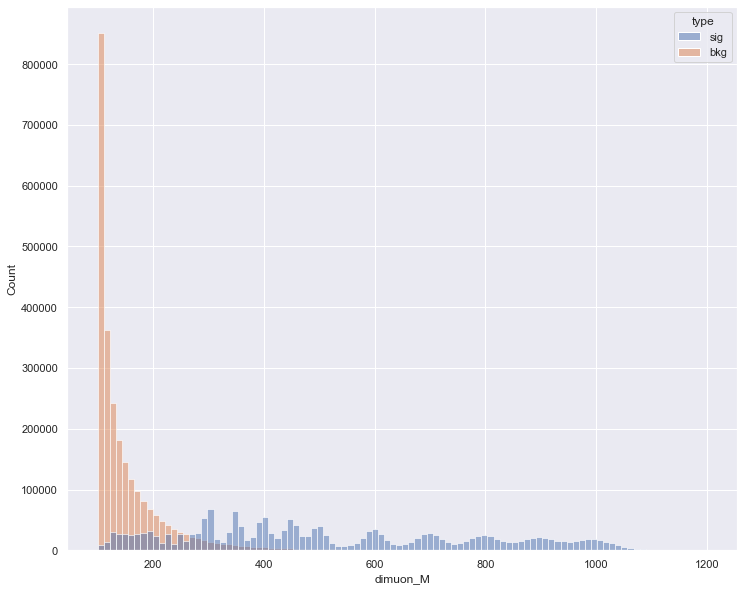

In [69]:
# plt.figure(figsize=(12, 10))
# df = data.ds[data.ds['dimuon_M'] < 1200]
# df['type'] = df['type'].apply(lambda x: 'bkg' if x == 0.0 else 'sig')

# sns.histplot(data=df, x='dimuon_M', hue='type', bins=100)

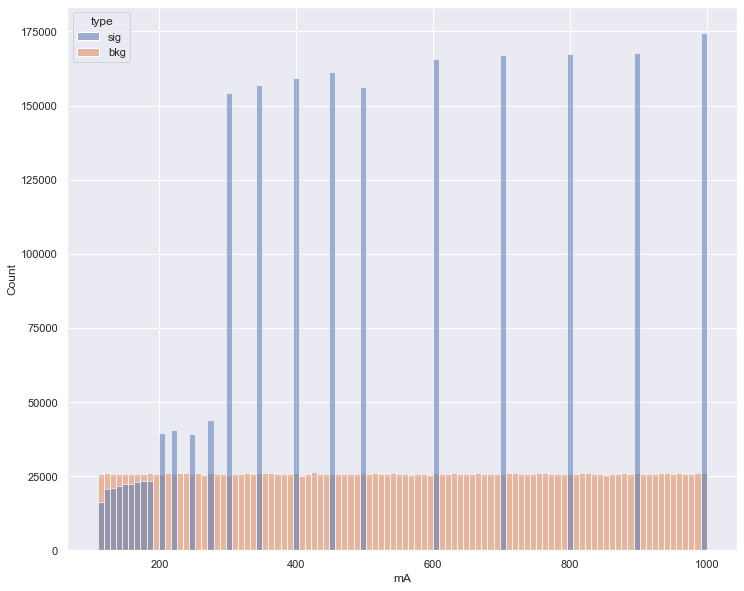

In [70]:
# plt.figure(figsize=(12, 10))
# df = data.ds#[data.ds['dimuon_M'] < 1200]
# df['type'] = df['type'].apply(lambda x: 'bkg' if x == 0.0 else 'sig')

# sns.histplot(data=df, x='mA', hue='type', bins=100)

---

In [5]:
def sample(df, amount: int, seed):
    if amount > df.shape[0]:
        x = []
        
        while amount > 0:
            x.append(df.sample(n=min(amount, df.shape[0]), random_state=seed))
            amount -= df.shape[0]
        
        return pd.concat(x, axis=0)
    
    return df.sample(n=amount, random_state=seed)

### Case 1
Condidered *signal* and *background* are both at `mA`, thus the bkg is sampled.

In [11]:
def cms_histplot1(dataset, col: str, mass, delta=50.0, bins=25, size=(12, 10), legend='best',
                  path='plot', weight=False, seed=utils.SEED, average=10, cat=1, save=None, 
                  balance_bkg=False, min_limit=None, max_limit=None):
    path = utils.makedir(path, f'cat-{cat}')
    
    fig = plt.figure(figsize=size)
    ax = fig.gca()
    
    if isinstance(seed, int):
        seed = np.random.RandomState(seed)
    
    sig, bkg = dataset.signal, dataset.background
    sig = sig[sig['mA'] == mass][col]
    
    num_sig = sig.shape[0]
    num_bkg = bkg.shape[0]

    s = [sig for _ in range(average)]
    w = 1.0 / average
    w_bkg = []
    
    if balance_bkg:
        bkgs = {k: bkg[bkg['name'] == k][col] for k in bkg['name'].unique()}
        frac = int(num_sig / len(bkgs.keys()))

        b = []
        for _ in range(average):
            for v in bkgs.values():
                b.append(sample(v, frac, seed))
    else:
        b = [bkg.sample(n=num_sig)[col] for _ in range(average)]
        w_bkg = [bkg.loc[b_.index]['weight'].values for b_ in b]
    
    sig = pd.concat(s, axis=0)
    bkg = pd.concat(b, axis=0)
    w_bkg = np.concatenate(w_bkg, axis=0)
    
    # compute weights
    h_bkg, _ = np.histogram(bkg, bins=bins, weights=w_bkg)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(sig) * (h_bkg / h_sig)
    
    names = dataset.names_df.loc[bkg.index]
    df = pd.DataFrame({col: bkg, 'Bkg': np.squeeze(names), 'weight': w_bkg})
    
    # feature range
    range_min = min(bkg.min(), sig.min())
    range_max = max(bkg.max(), sig.max())
    
    if isinstance(min_limit, (int, float)):
        range_min = max(range_min, min_limit)
    
    if isinstance(max_limit, (int, float)):
        range_max = min(range_max, max_limit)
    
    # plot histograms
    sns.histplot(data=df, x=col, hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=bins,
                 weights='weight' if weight else None, ax=ax, binrange=(range_min, range_max),
                 palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})
    
    ax.hist(sig, bins=bins, alpha=0.7, label='signal', color='purple', edgecolor='purple', 
            linewidth=2, hatch='//', histtype='step',
            range=(range_min, range_max),
            weights=w_sig if weight else None)
    
    leg = ax.get_legend()
    ax.legend(loc='upper left')
    ax.add_artist(leg)
    
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    
    weighted = '; weigted' if weight is True else '; not weighted'
    averaged = '' if average <= 1 else f'({average} sampled average)'
    bkg_str = 'all background' if average <= 1 else 'sampled_background'
    
    str1 = f'[Case 1] Category {cat} #bins = {bins} {averaged}'
    str2 = f'\"{col}\" distribution @ {int(mass)}mA (signal); {bkg_str}'
    str3 = f'# signal = {num_sig}, # bkg = {num_bkg}'
    
    if balance_bkg:
        d = {k: v.shape[0] for k, v in bkgs.items()}
        str3 = f'{str3} {d}'
    
    ax.set_title(f'{str1}\n{str2}\n{str3}')
    
    if isinstance(save, str):
        plt.savefig(os.path.join(path, f'{save}.png'), bbox_inches='tight')
        
    plt.show()
    
    return {'#signal': num_sig, '#bkg': num_bkg}

### bbH

In [7]:
VAR_CAT1 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt", 
             "deltar_bjet1_dimuon", "deltapt_bjet1_dimuon", "deltaeta_bjet1_dimuon", 
             "bjet_1_pt", "bjet_1_eta", "deltaphi_bjet1_dimuon", "dimuon_pt",
             "ljet_1_pt", "ljet_1_eta", "bjet_n", "ljet_n"]

In [8]:
VAR_CAT2 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt",
            "dimuon_pt",
            "ljet_1_pt", "ljet_1_eta", "ljet_n"]

##### Category 1

In [9]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat1.csv', 
          bkg='data/new/background_cat1.csv', feature_columns=VAR_CAT1, add_var=True)

[signal] loading...
[background] loading...
[Dataset] loaded.


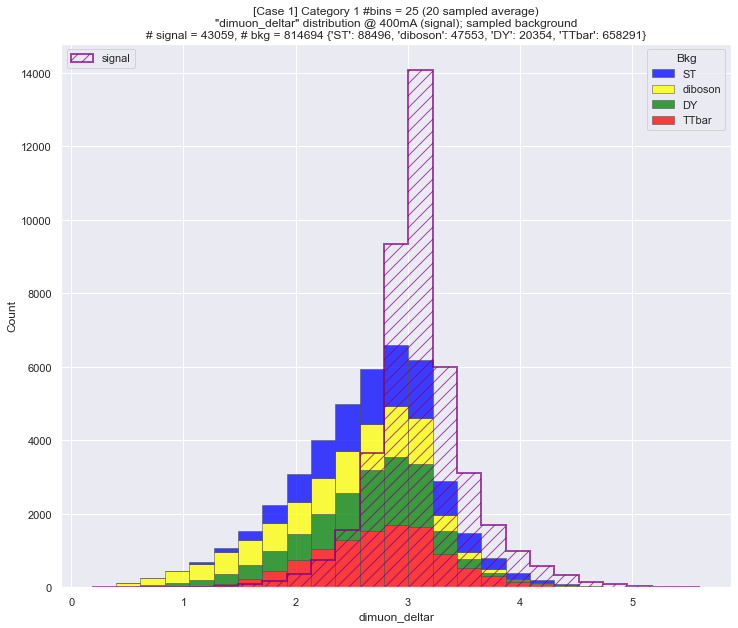

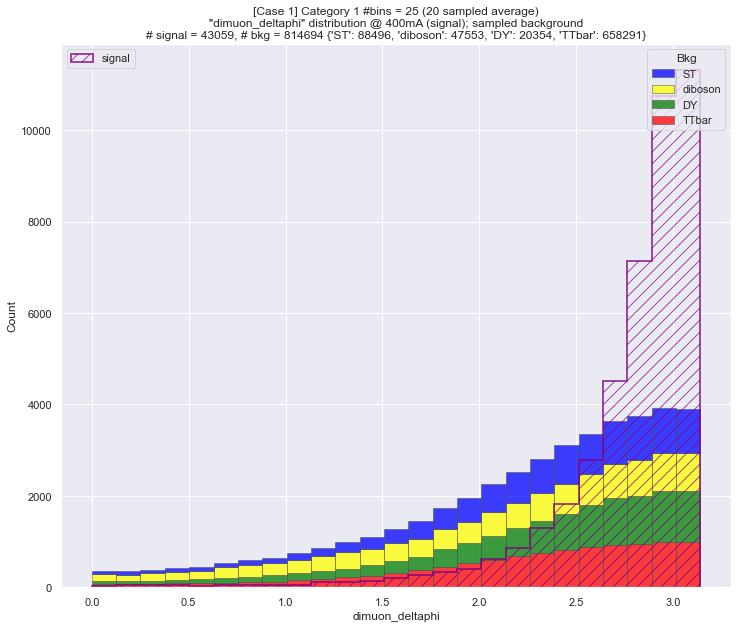

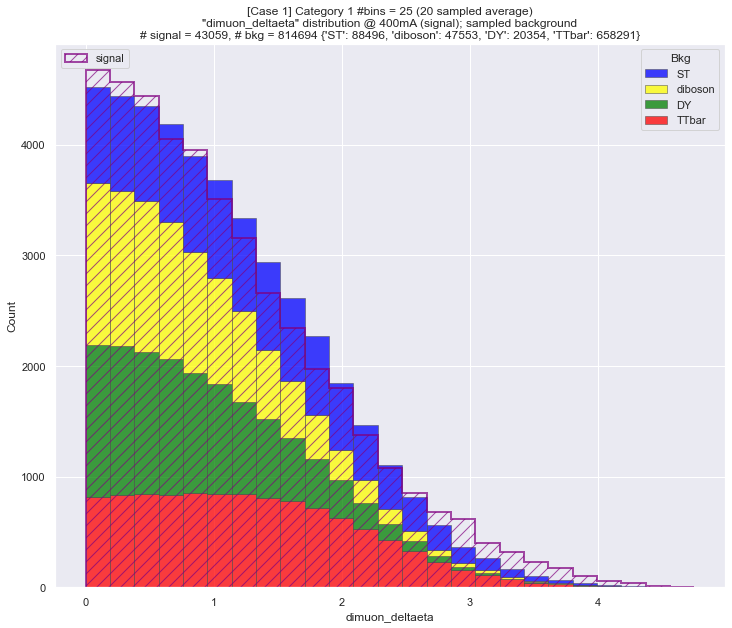

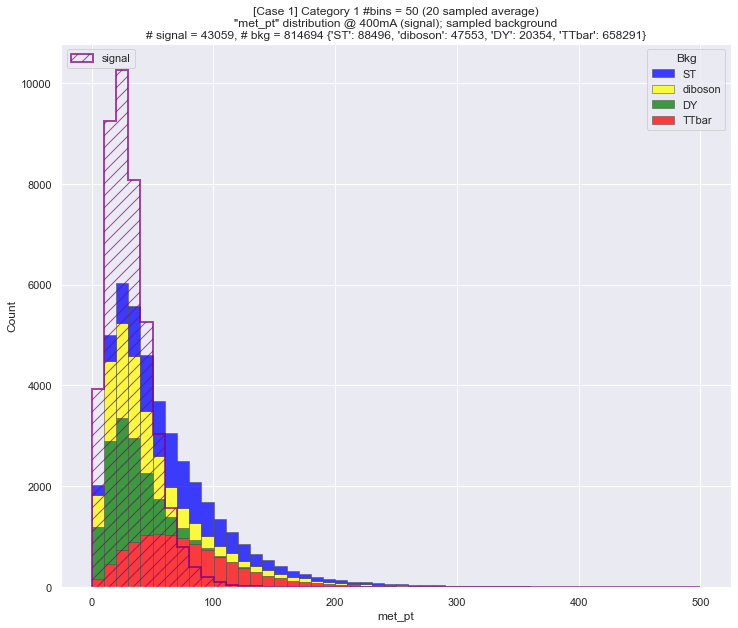

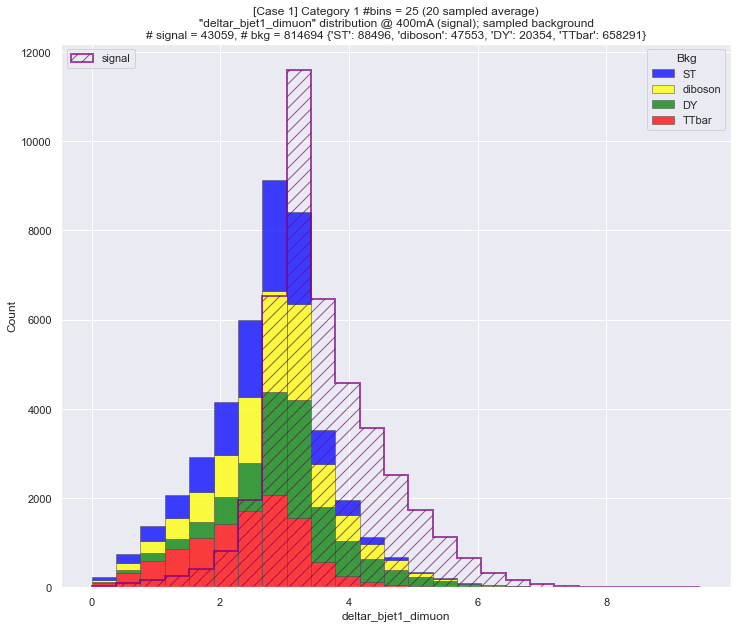

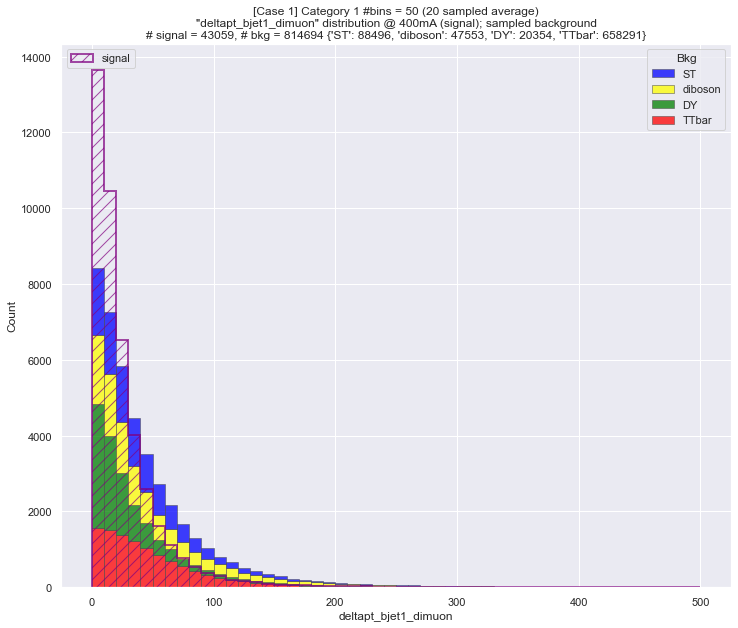

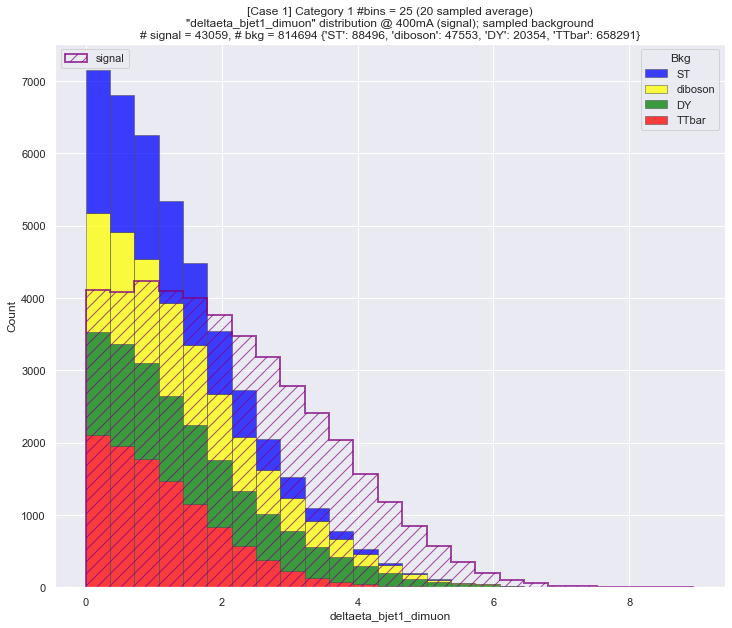

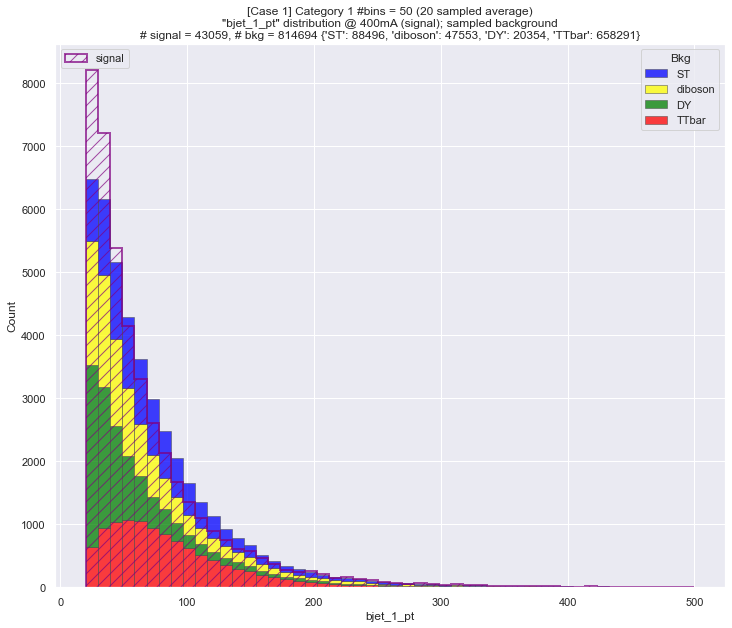

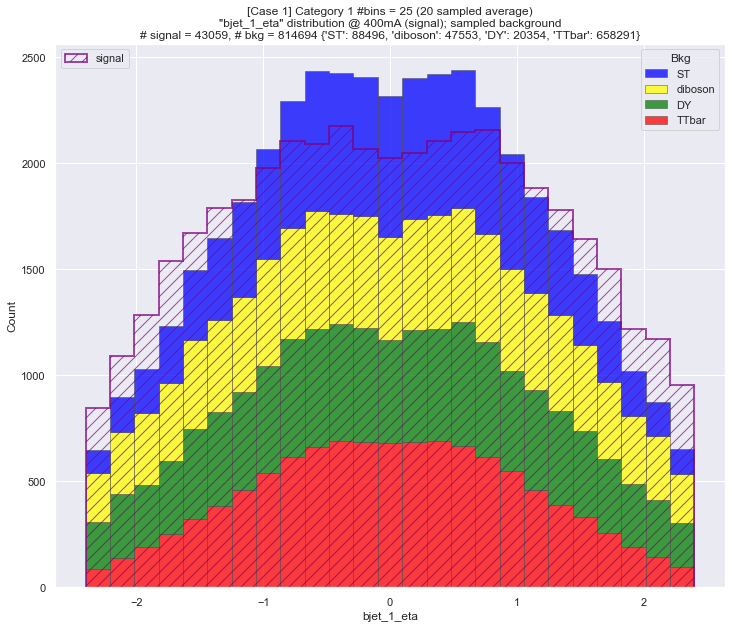

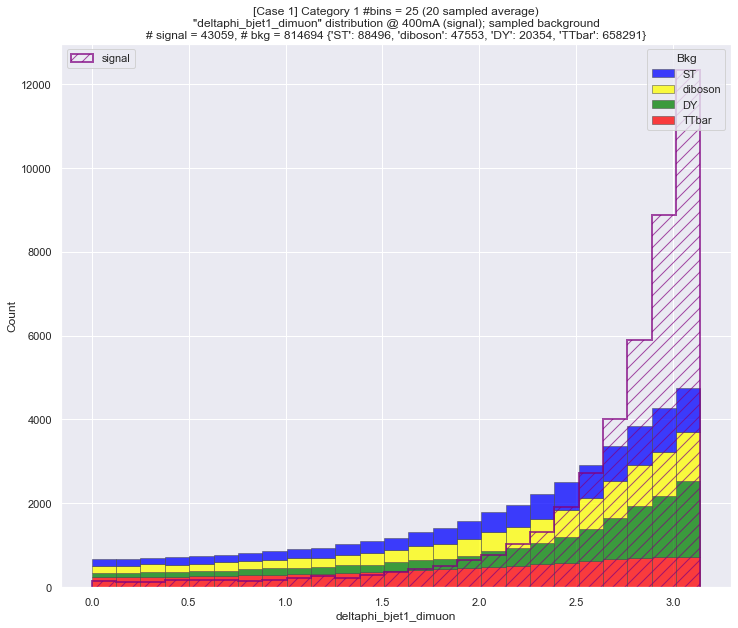

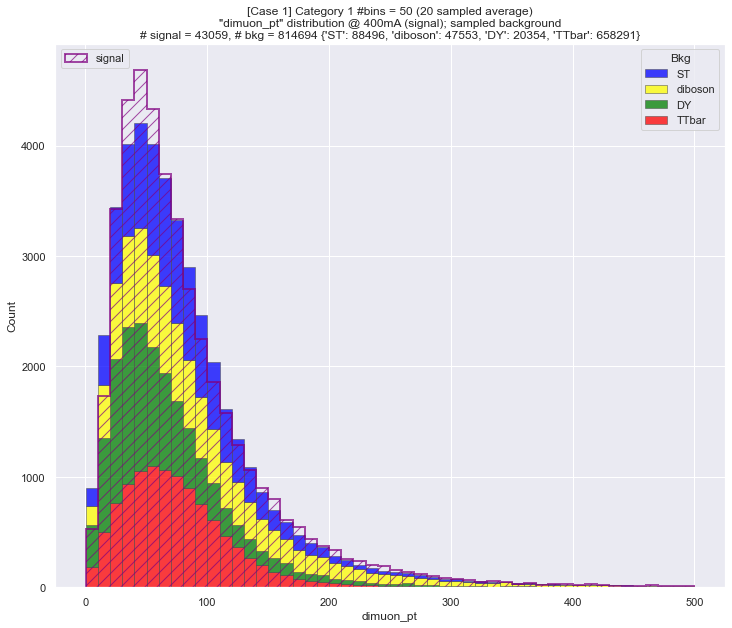

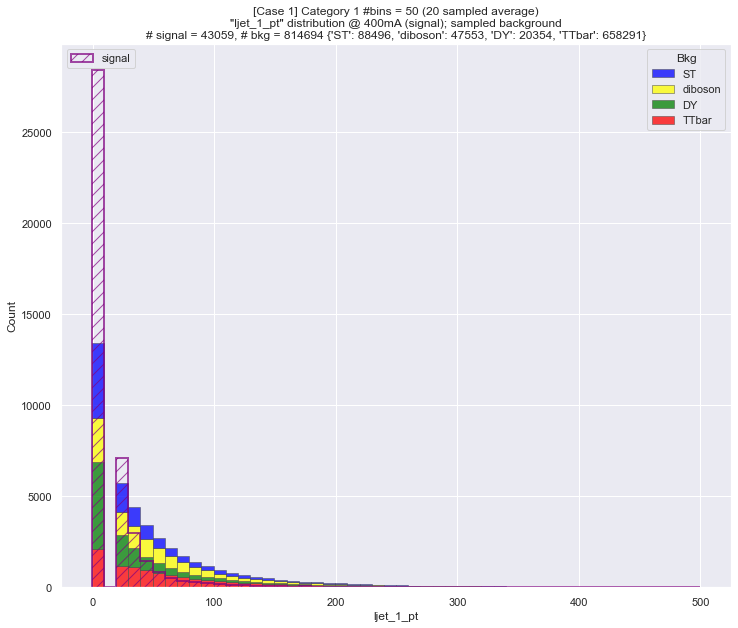

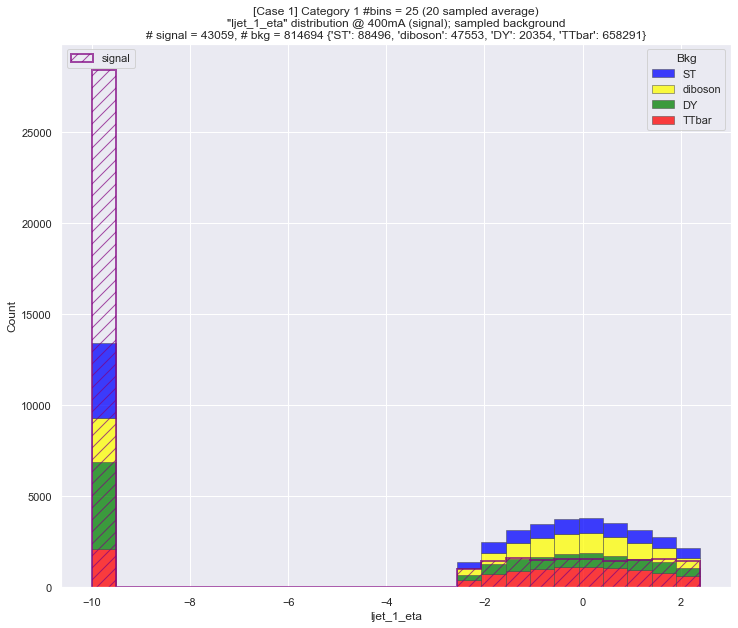

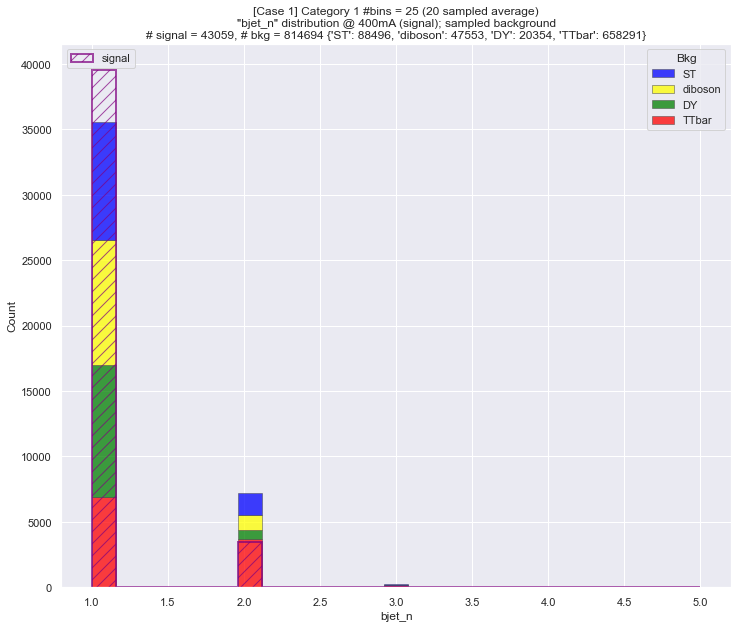

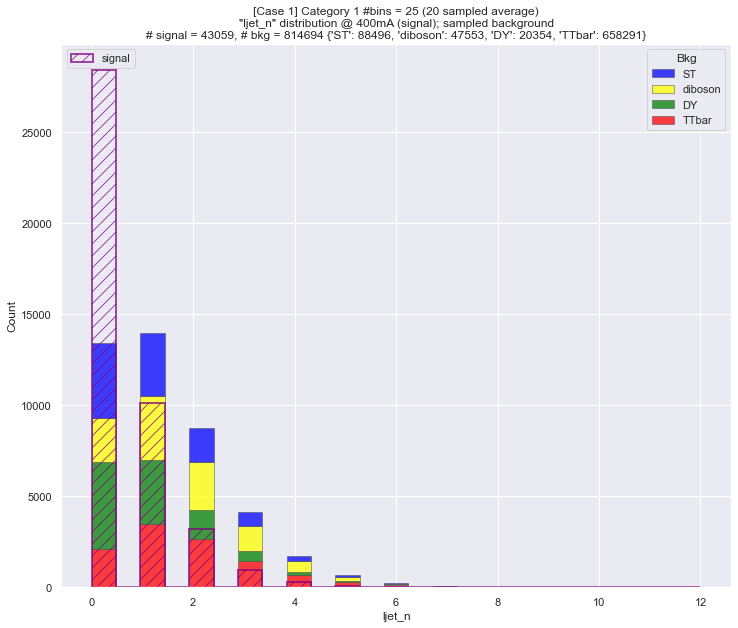

In [44]:
for var in VAR_CAT1:
    if ('met' in var) or ('pt' in var):
        bins = 50
        max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot1(data, col=var, mass=400.0, average=20, bins=bins, delta=50.0, balance_bkg=True,
                  path='plot/case1/bbH/', save=f'{var}_400mA', max_limit=max_limit)

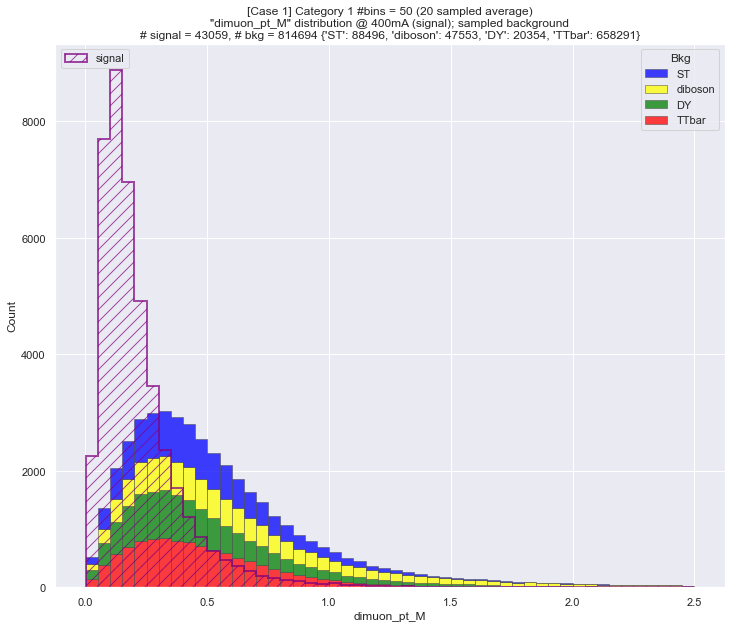

{'#signal': 43059, '#bkg': 814694}

In [12]:
cms_histplot1(data, col='dimuon_pt_M', mass=400.0, average=20, bins=50, delta=50.0, balance_bkg=True,
              path='plot/case1/bbH/', save='dimuon_pt_M_400mA', max_limit=2.5)

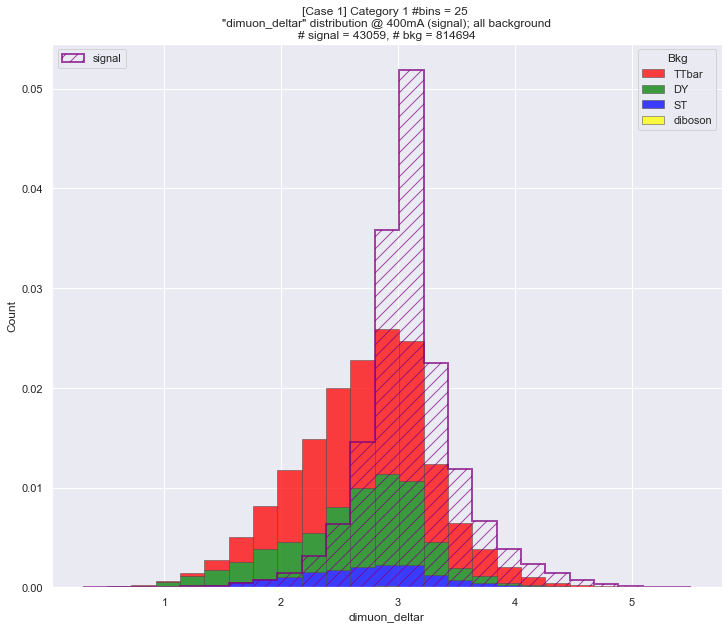

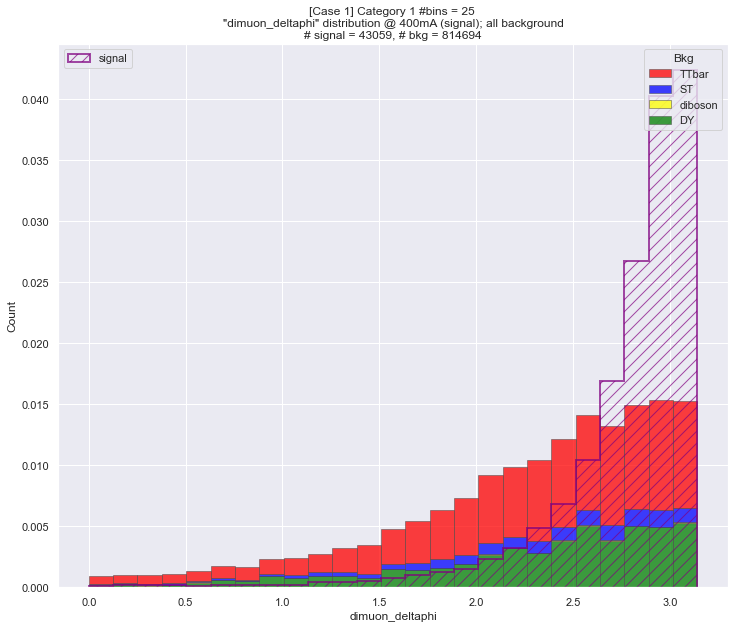

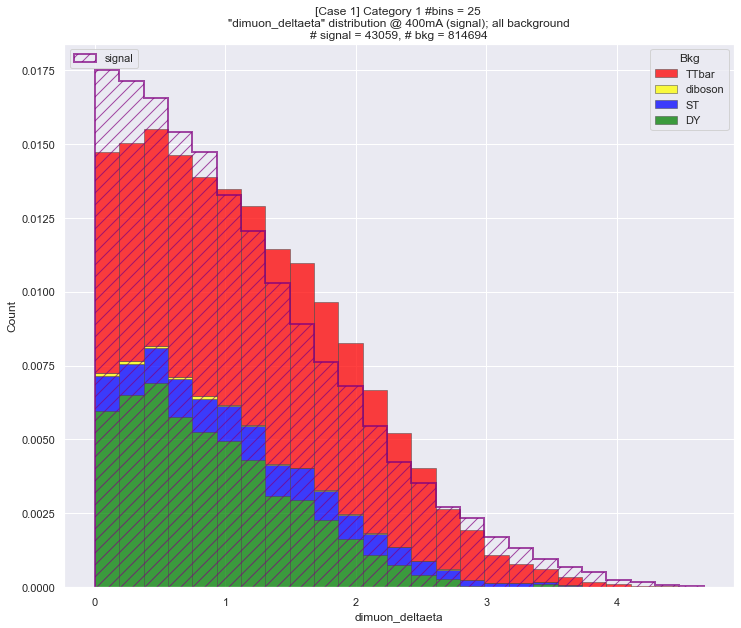

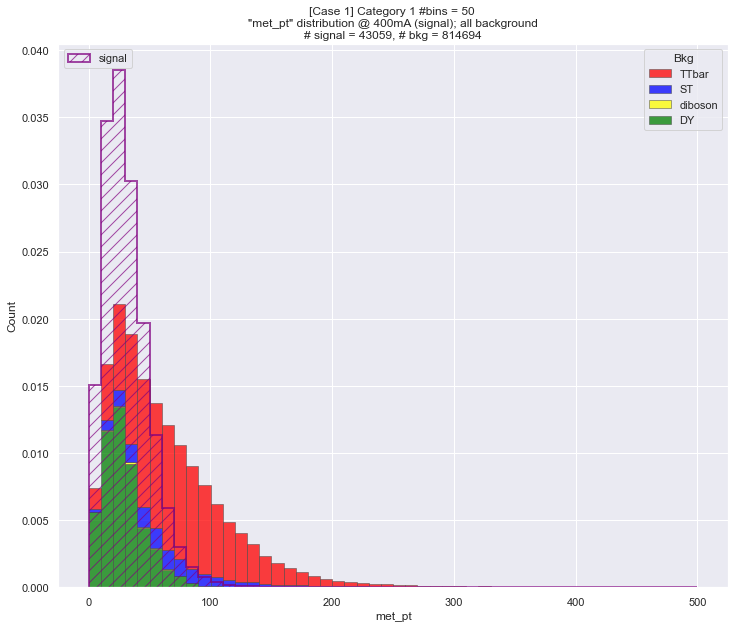

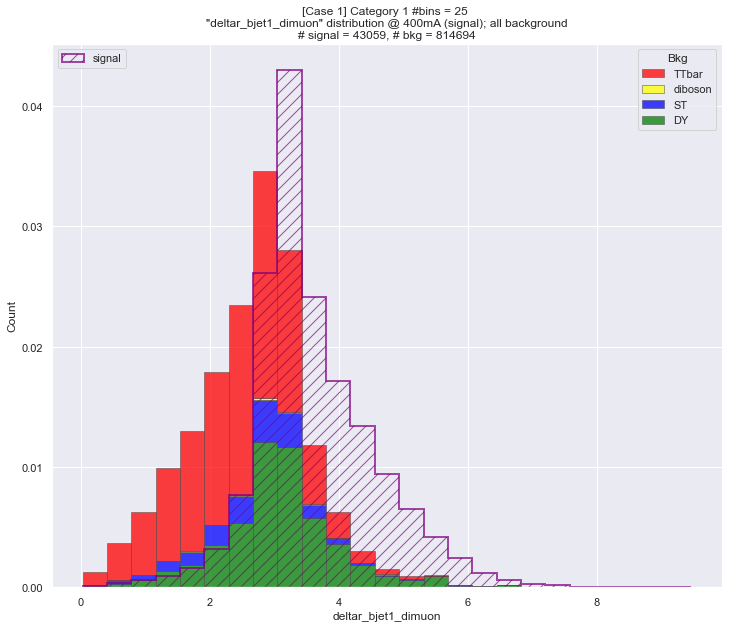

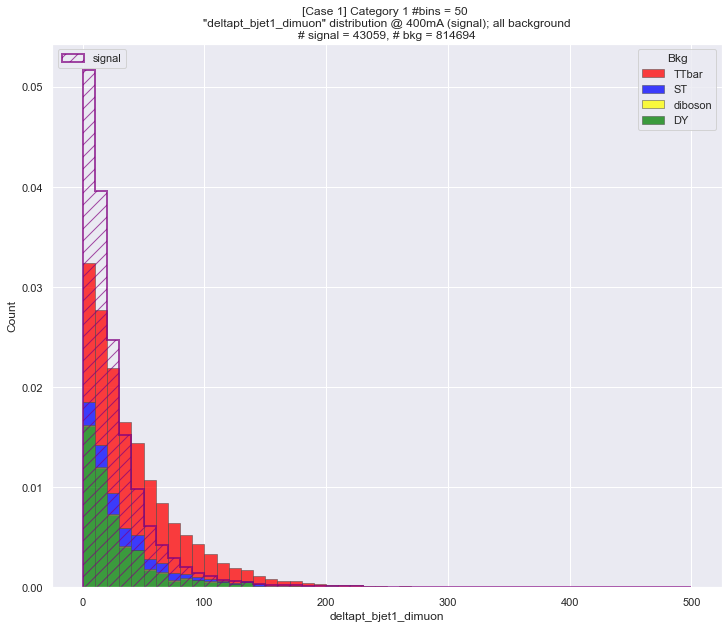

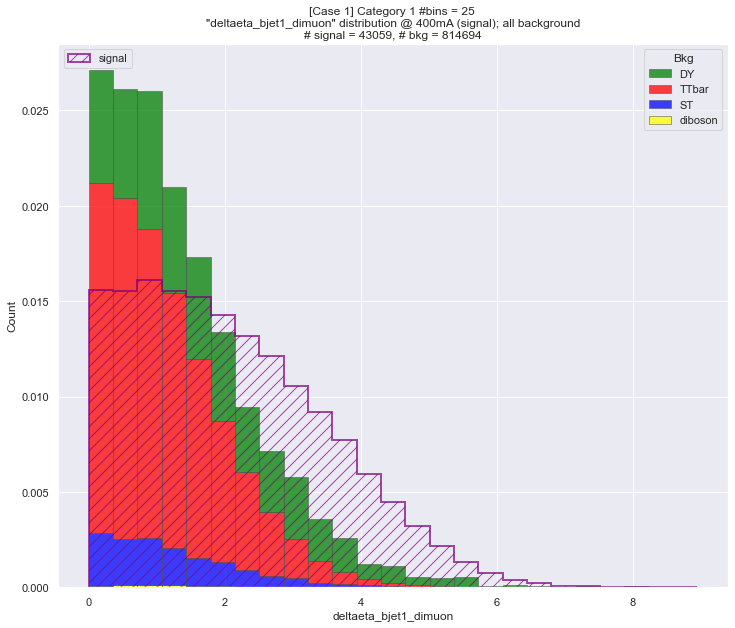

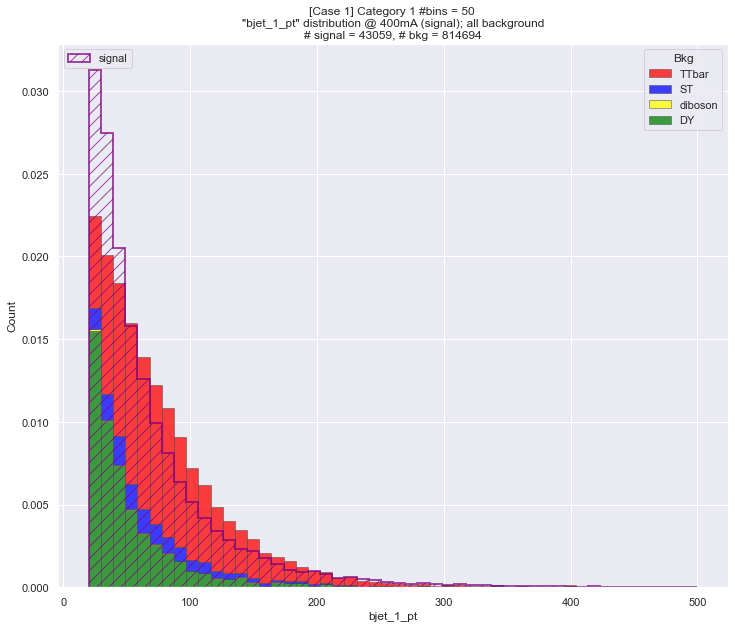

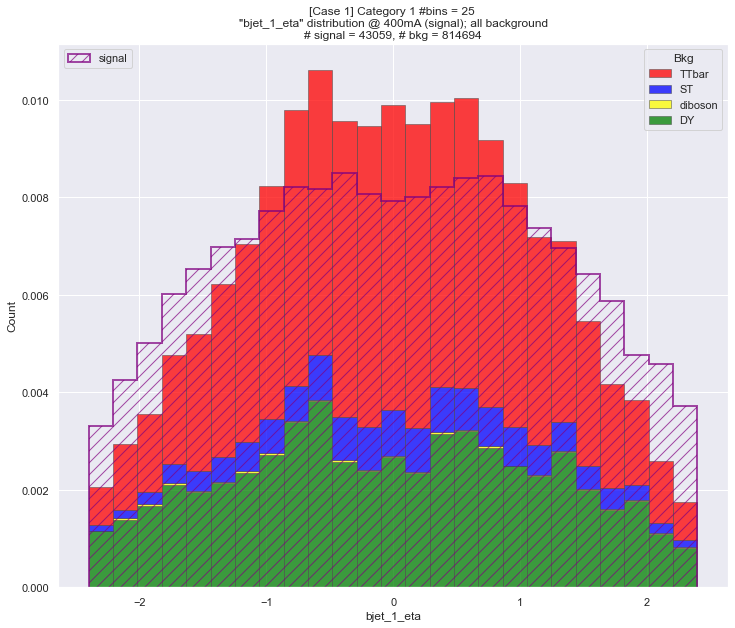

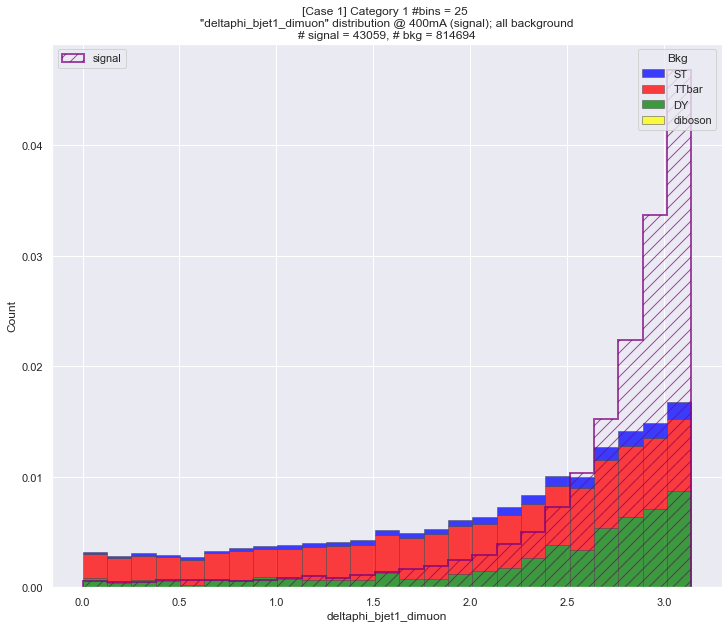

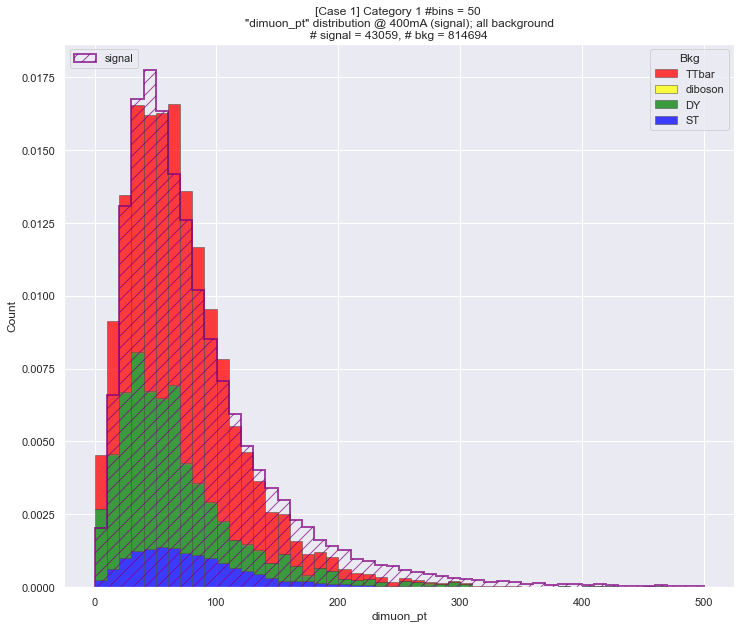

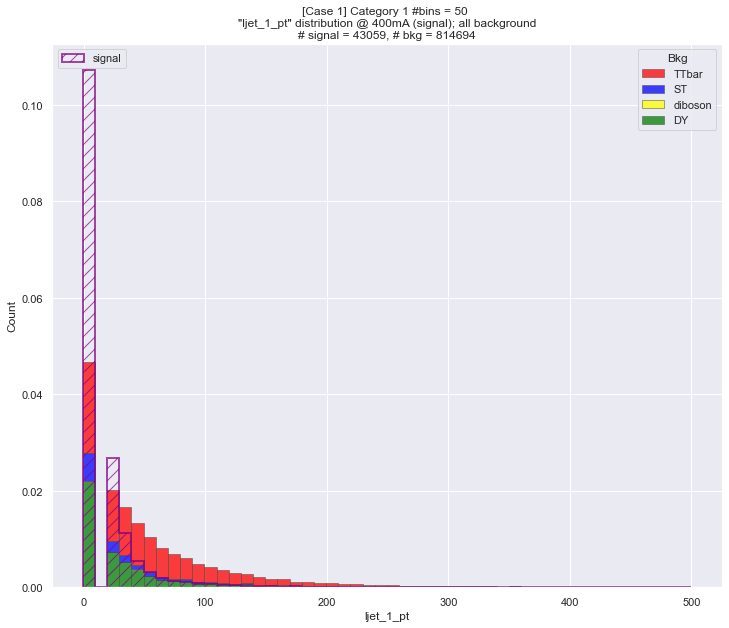

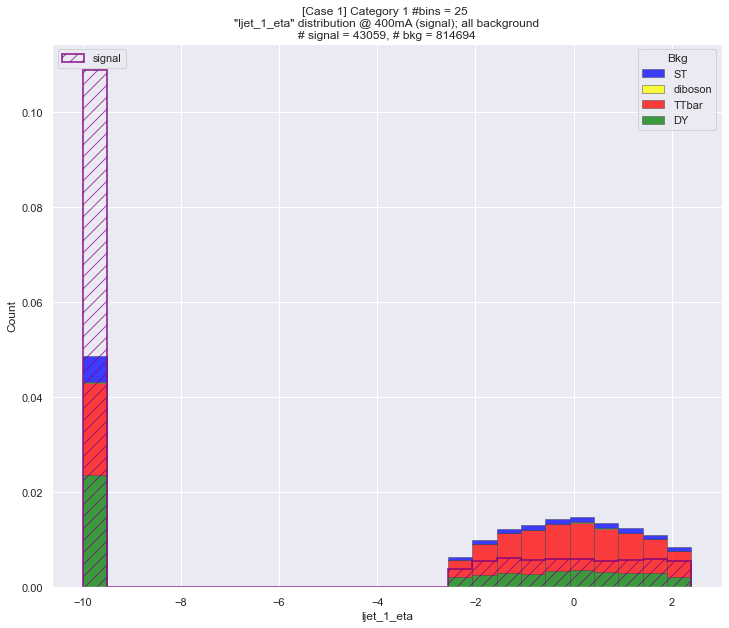

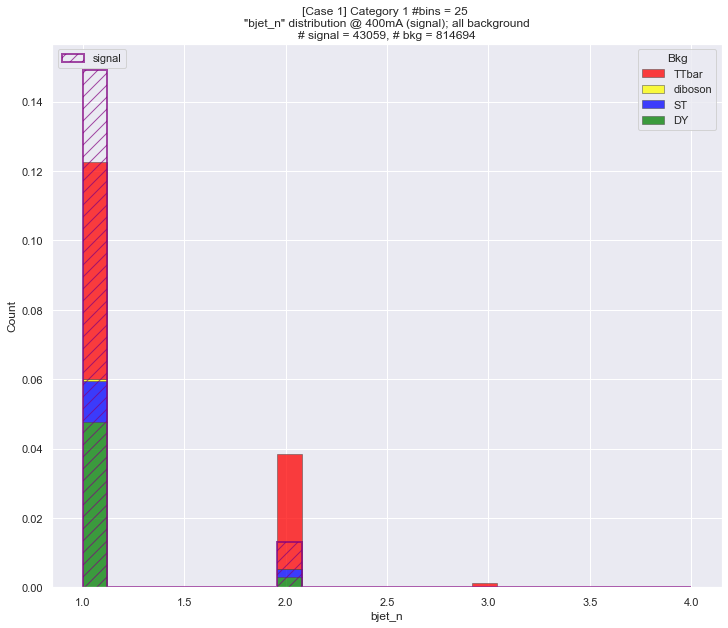

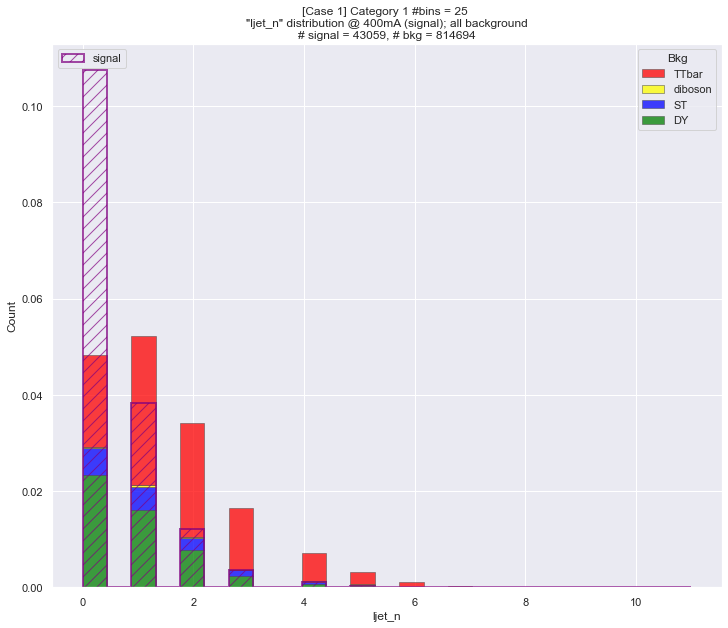

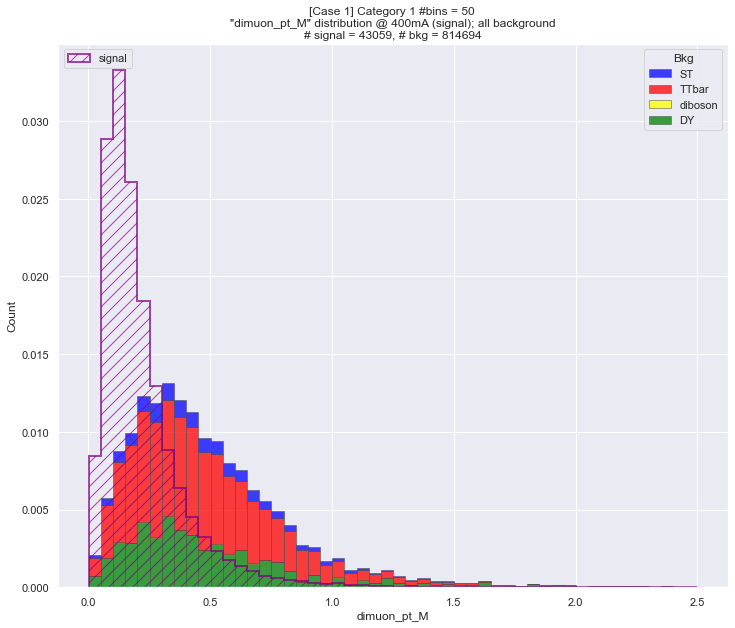

In [12]:
for var in VAR_CAT1:
    if ('met' in var) or ('pt' in var):
        bins = 50
        
        if var == 'dimuon_pt_M':
            max_limit = 2.5
        else:
            max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot1(data, col=var, mass=400.0, average=1, bins=bins, delta=50.0, balance_bkg=False, 
                  weight=True,
                  path='plot/plot/category 1/bbH/case 1 (all bkg)/weighted/', save=f'{var}_400mA', max_limit=max_limit)

##### Category 2

In [13]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat2.csv', 
          bkg='data/new/background_cat2.csv', feature_columns=VAR_CAT2, add_var=True)

[signal] loading...
[background] loading...
[Dataset] loaded.


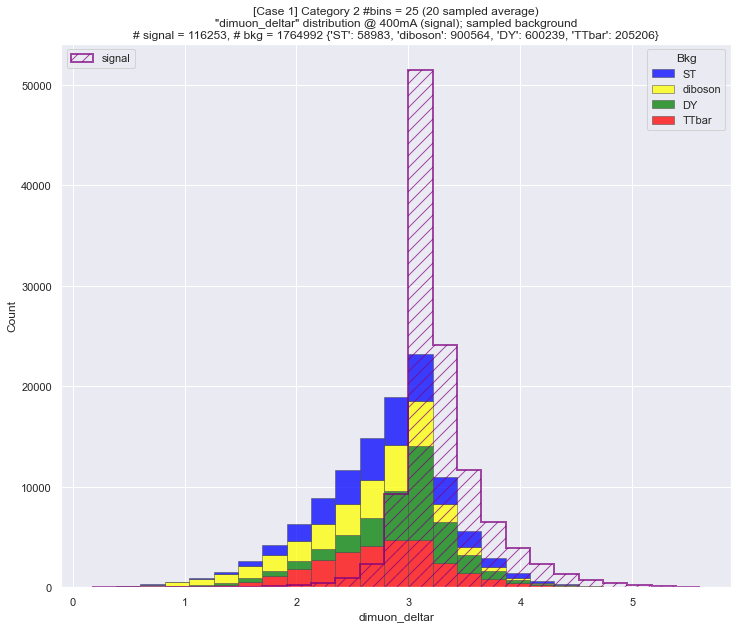

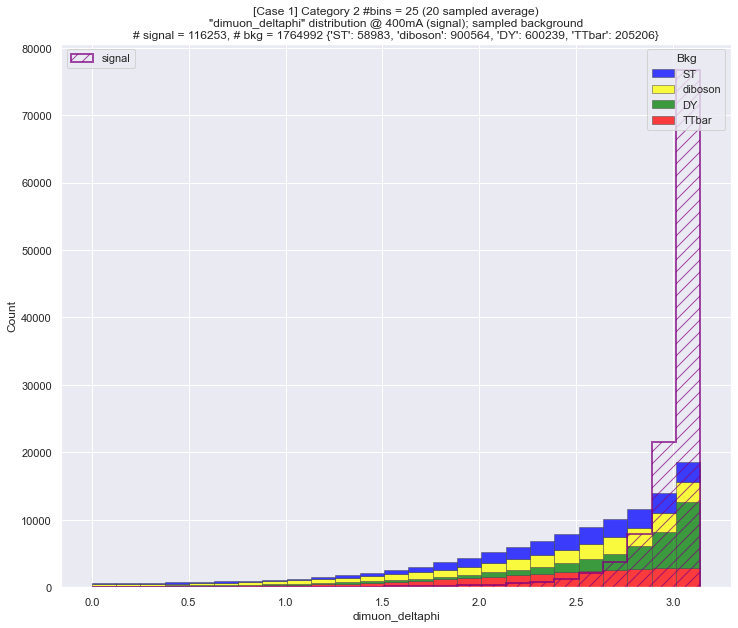

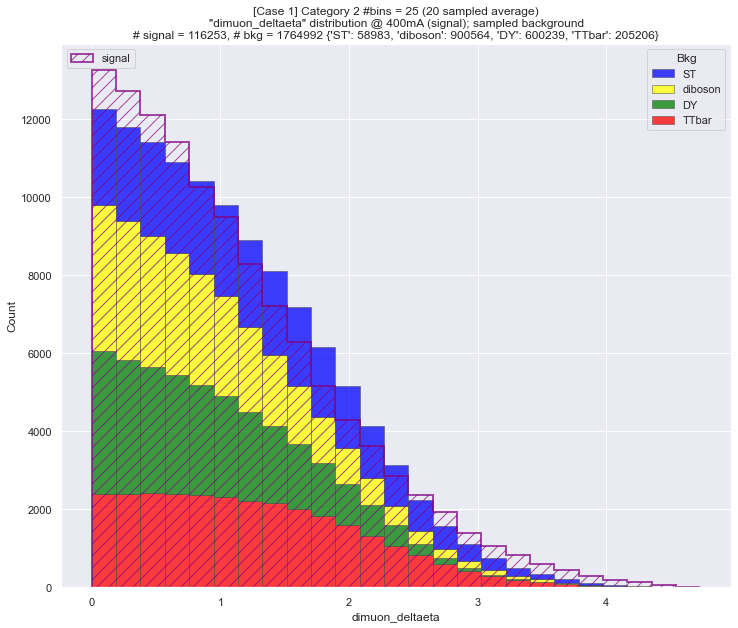

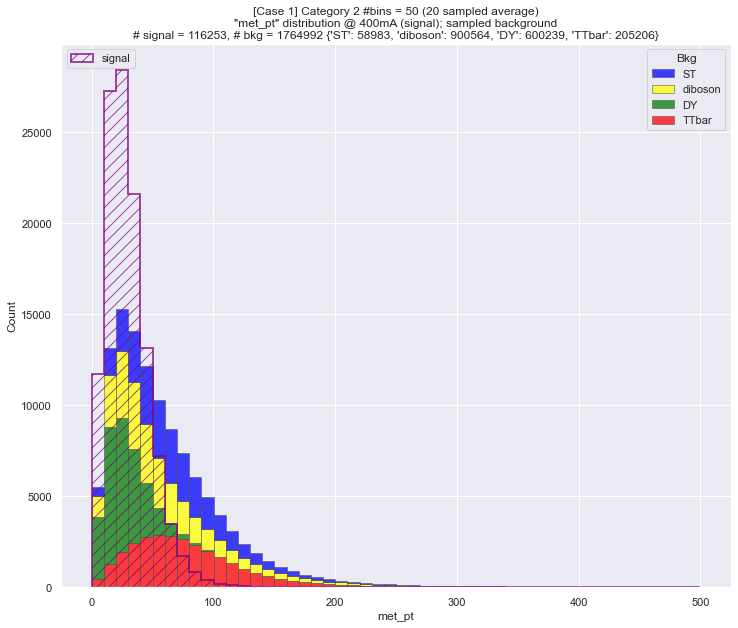

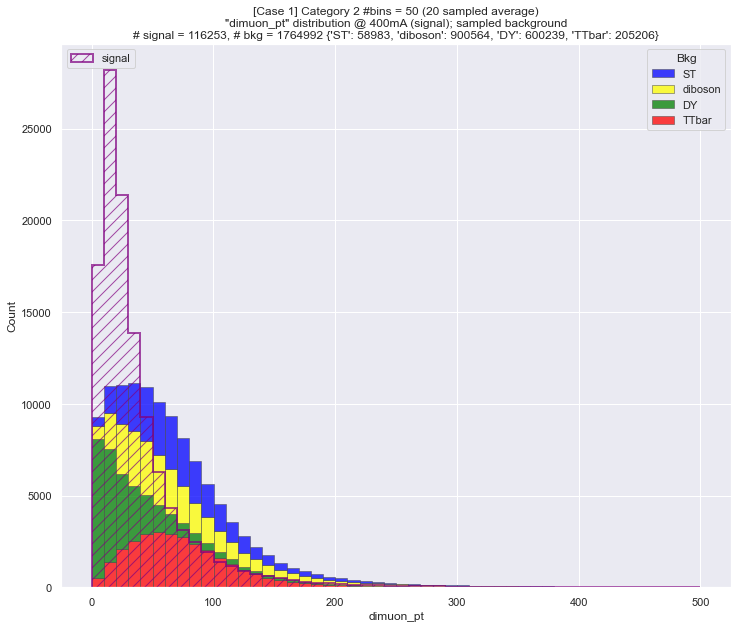

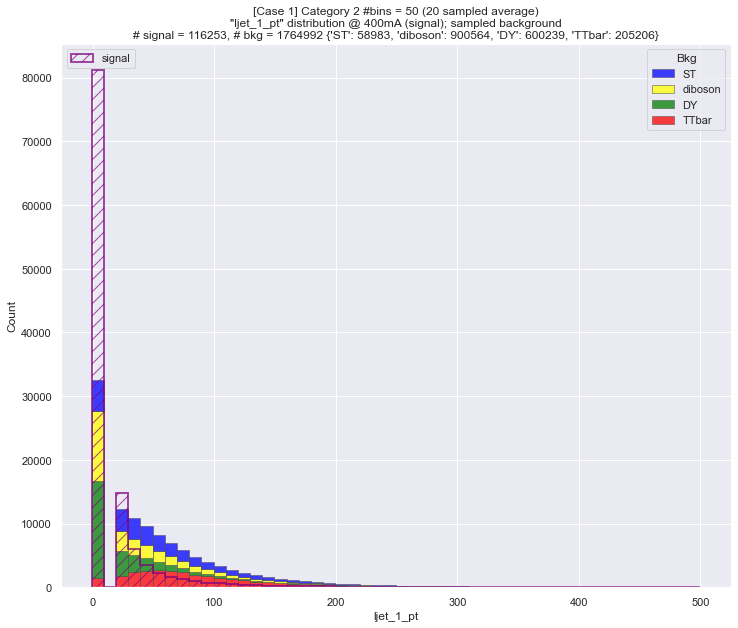

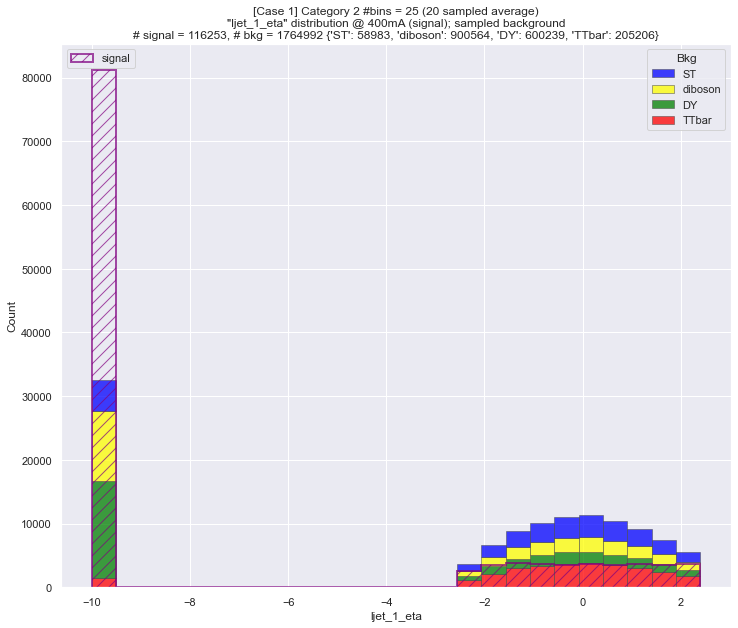

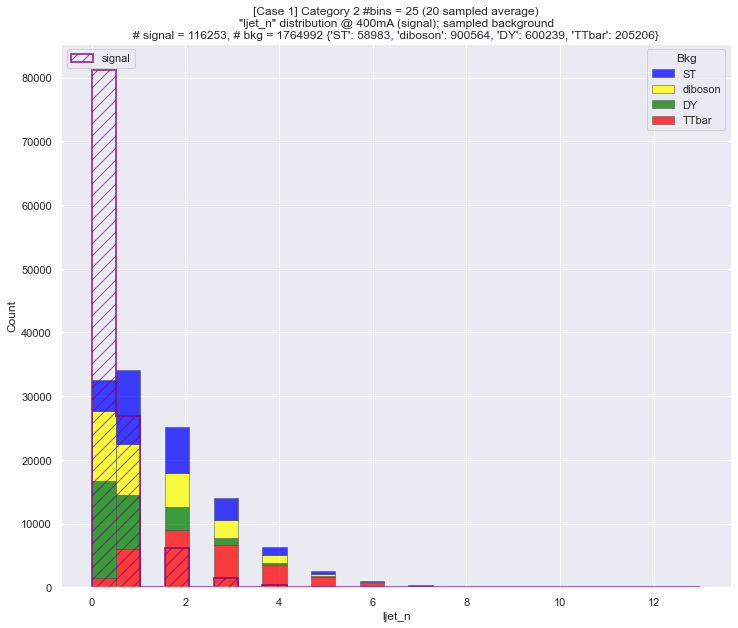

In [41]:
for var in VAR_CAT2:
    if ('met' in var) or ('pt' in var):
        bins = 50
        max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot1(data, col=var, mass=400.0, average=20, bins=bins, delta=50.0, balance_bkg=True,
                  cat=2,
                  path='plot/case1/bbH/', save=f'{var}_400mA', max_limit=max_limit)

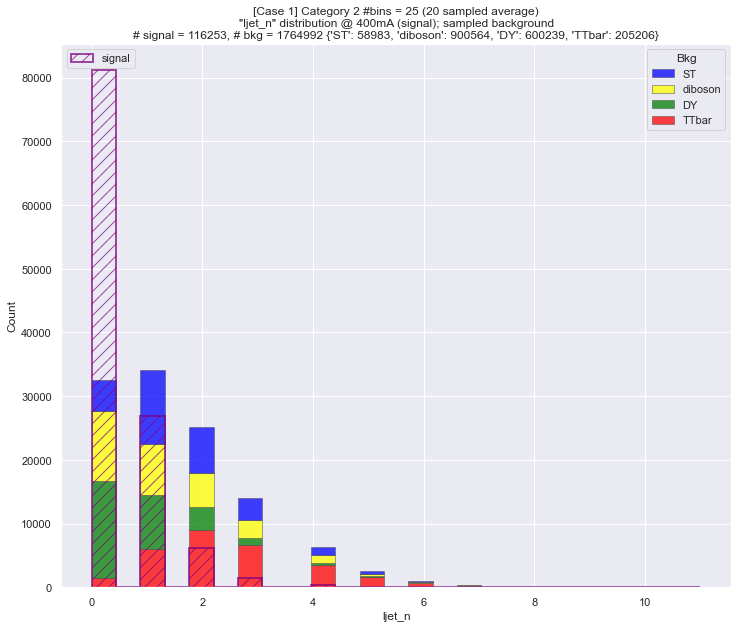

In [11]:
for var in ['ljet_n']:
    cms_histplot1(data, col=var, mass=400.0, average=20, bins=25, delta=50.0, balance_bkg=True,
                  cat=2,
                  path='plot/case1/bbH/', save=f'{var}_400mA', max_limit=11.0)

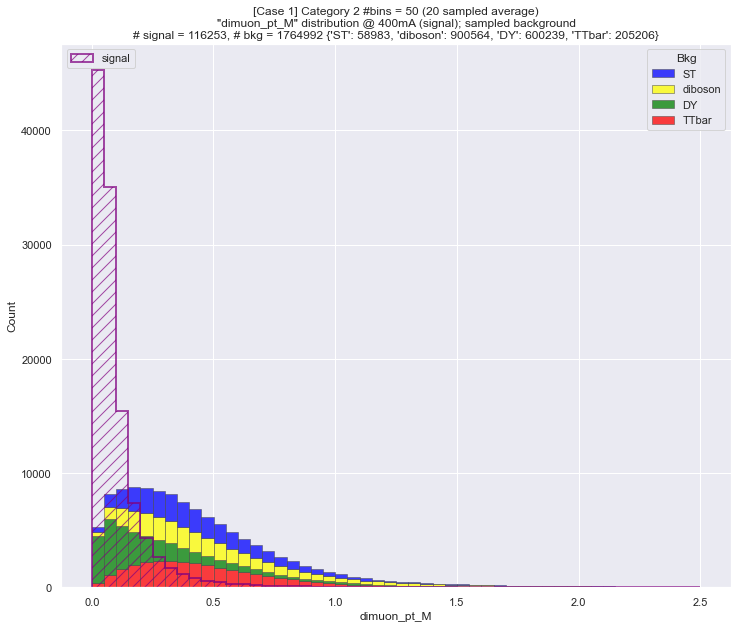

In [16]:
for var in ['dimuon_pt_M']:
    cms_histplot1(data, col=var, mass=400.0, average=20, bins=50, delta=50.0, balance_bkg=True,
                  cat=2,
                  path='plot/case1/bbH/', save=f'{var}_400mA', max_limit=2.5)

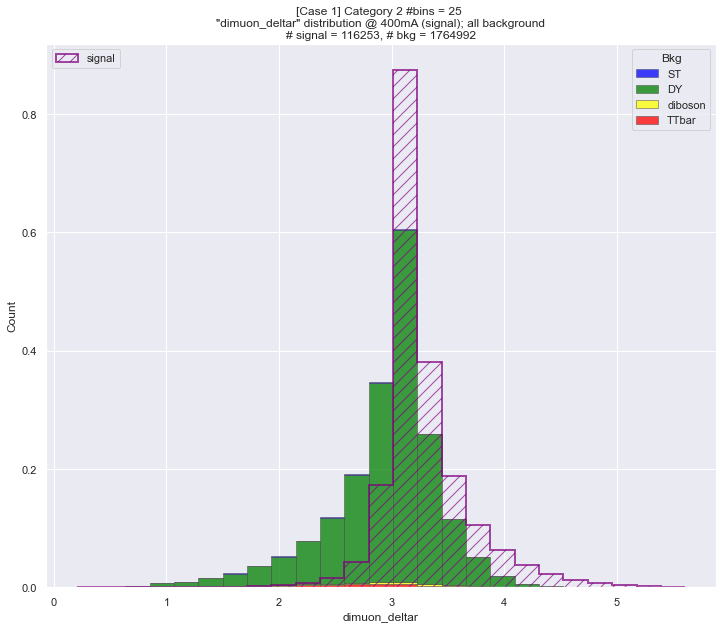

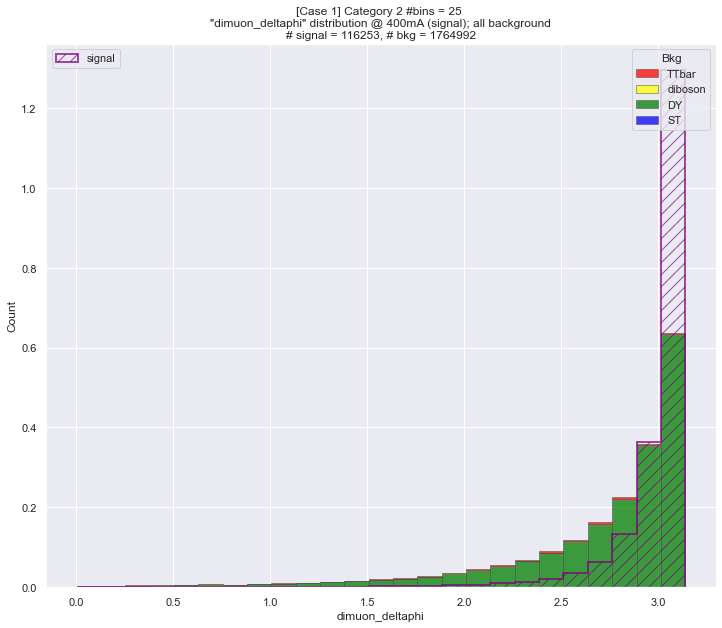

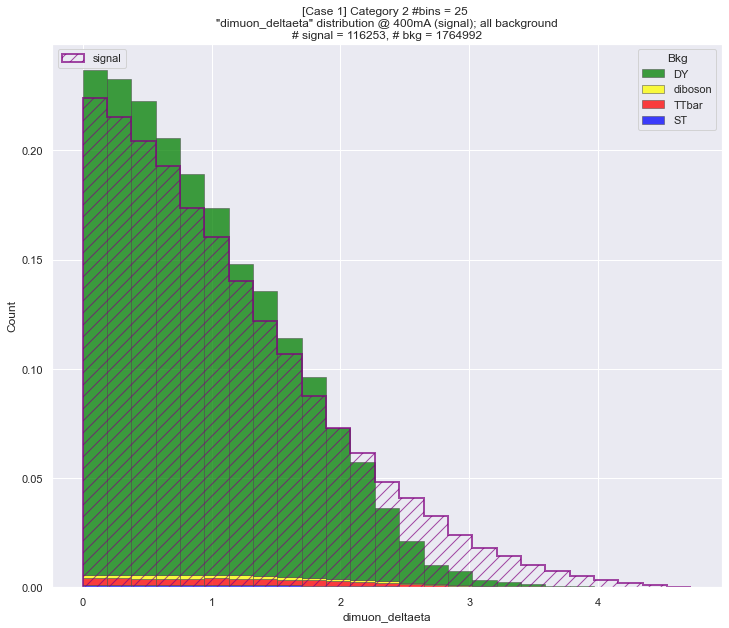

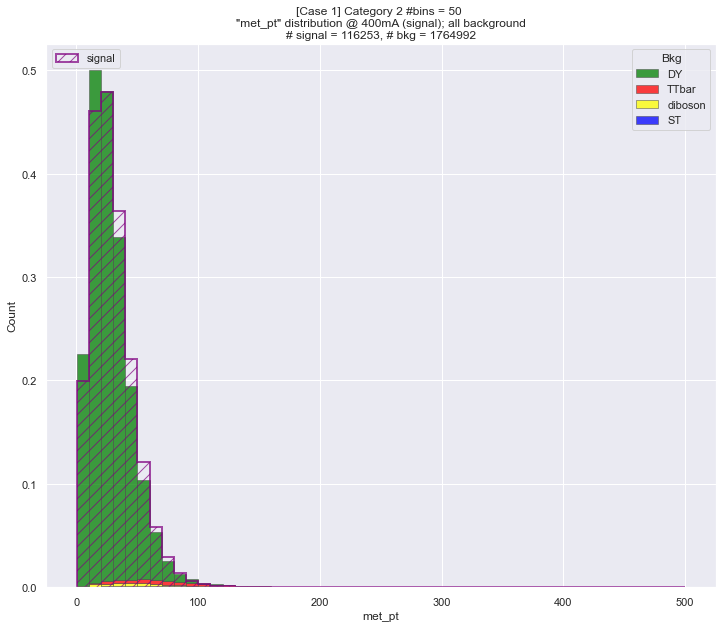

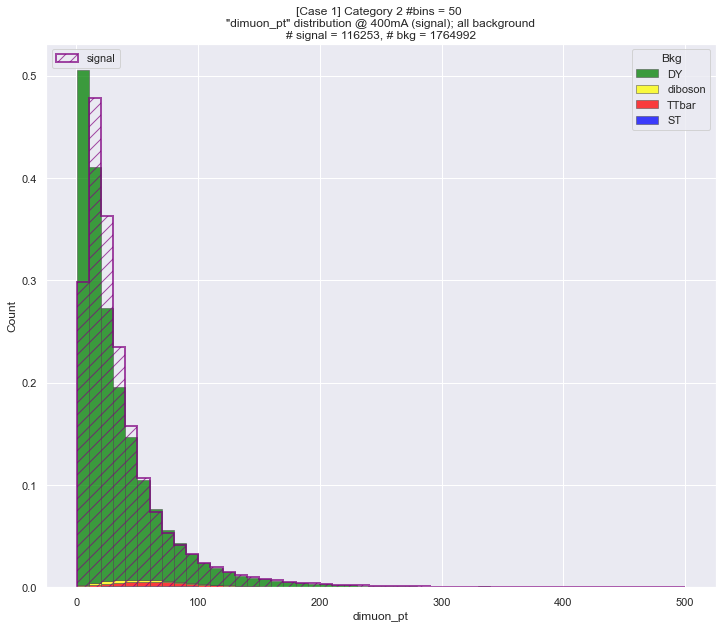

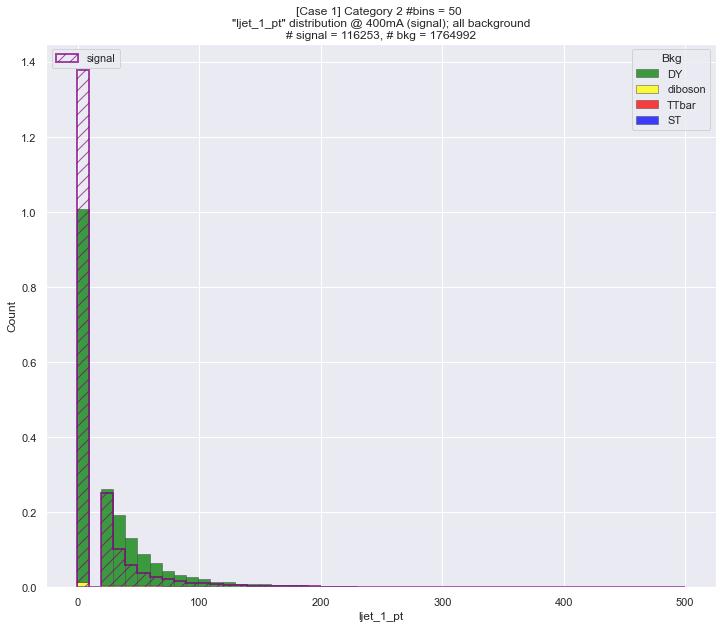

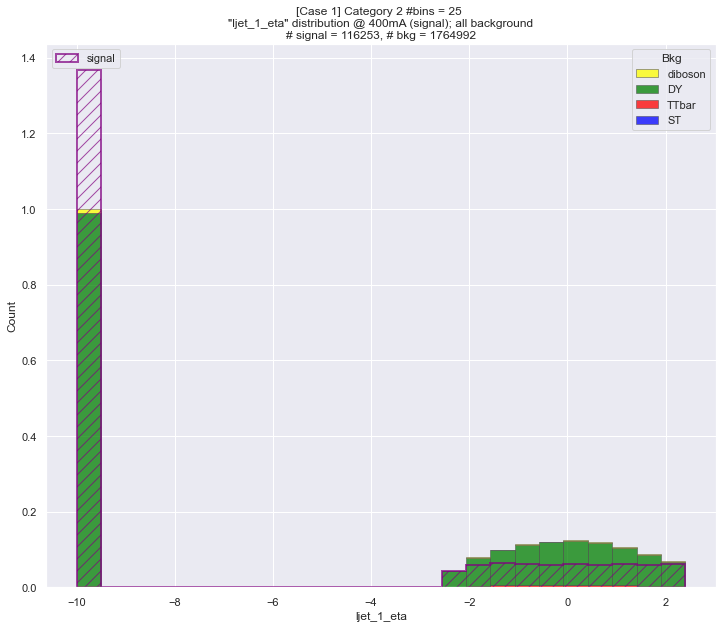

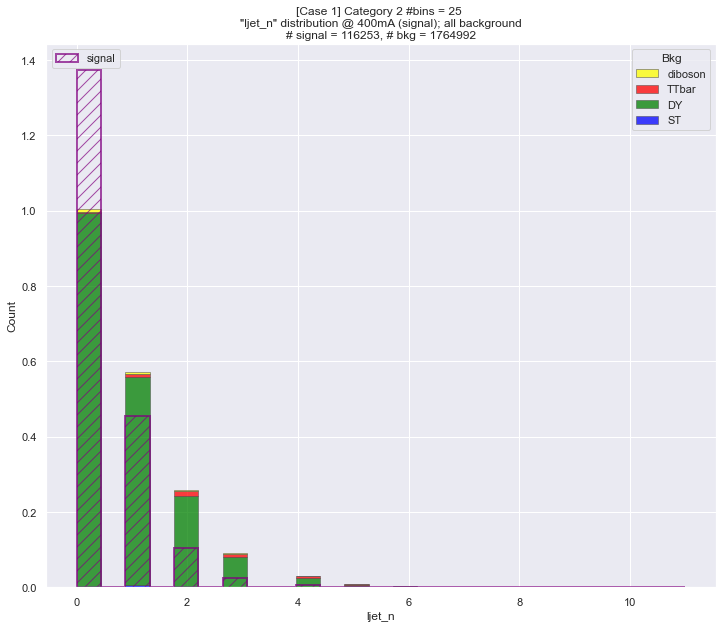

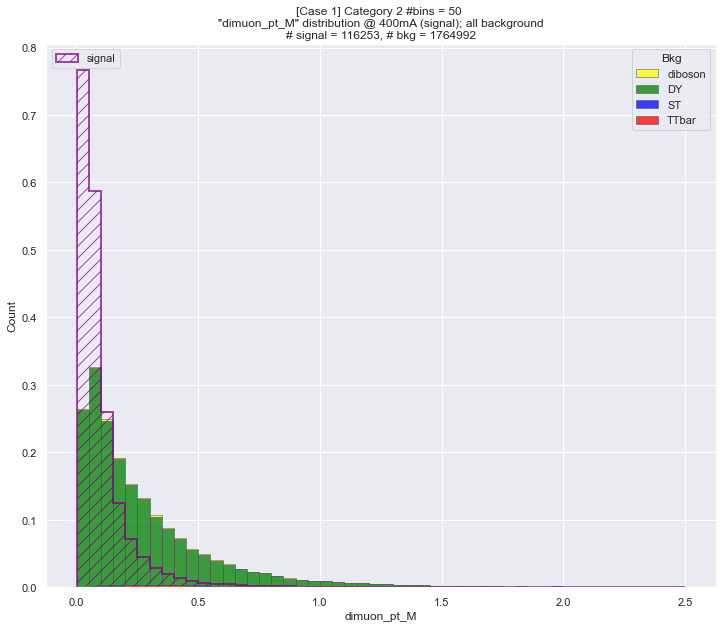

In [15]:
for var in VAR_CAT2:
    if ('met' in var) or ('pt' in var):
        bins = 50
        
        if var == 'dimuon_pt_M':
            max_limit = 2.5
        else:
            max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot1(data, col=var, mass=400.0, average=1, bins=bins, delta=50.0, balance_bkg=False, 
                  weight=True, cat=2,
                  path='plot/case1/bbH/weighted', save=f'{var}_400mA', max_limit=max_limit)

### Case 2
Condidered *signal* is at `mA`, whereas the *background* is considered at `dimuon_M` in an interval centered around mA.

In [32]:
def cms_histplot2(dataset, col: str, mass, cat: int, delta=50.0, bins=25, size=(12, 10), 
                  legend='best', path='plot', weight=False, seed=utils.SEED, average=10, 
                  save=None, balance_bkg=False, min_limit=None, max_limit=None):
    path = utils.makedir(path, f'cat-{cat}')
    
    fig = plt.figure(figsize=size)
    ax = fig.gca()
    
    if isinstance(seed, int):
        seed = np.random.RandomState(seed)
    
    sig, bkg = dataset.signal, dataset.background
    
    sig = sig[sig['mA'] == mass][col]
    bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    num_sig = sig.shape[0]
    num_bkg = bkg.shape[0]
    should_average = (num_sig != num_bkg) and (not average == 1)

    if should_average:
        assert average > 1
        
        s = []  # signal
        b = []  # bkg
        
        if balance_bkg:
            bkgs = {k: bkg[bkg['name'] == k][col] for k in bkg['name'].unique()}
        
        if num_sig > num_bkg:
            frac = int(num_bkg / len(bkgs.keys()))
        
            for _ in range(average):
                s.append(sample(sig, num_bkg, seed))
                
                if balance_bkg:
                    b.extend([sample(v, frac, seed) for v in bkgs.values()])
                else:
                    b.append(bkg)
        else:
            frac = int(num_sig / len(bkgs.keys()))
            
            for _ in range(average):
                s.append(sig)
                
                if balance_bkg:
                    b.extend([sample(v, frac, seed) for v in bkgs.values()])
                else:
                    b.append(bkg.sample(n=num_bkg, random_state=seed))
        
        w = 1.0 / average
        
        sig = pd.concat(s, axis=0)
        bkg = pd.concat(b, axis=0)
    else:
        if weight:
            w = bkg['weight'].values
        else:
            w = 1.0
    
        bkg = bkg[col]
    
    # compute weights
    h_bkg, _ = np.histogram(bkg, bins=bins, weights=w)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(sig) * (h_bkg / h_sig)
    
    names = dataset.names_df.loc[bkg.index]
    df = pd.DataFrame({col: bkg, 'Bkg': np.squeeze(names), 'weight': np.ones_like(bkg.values) * w})
    
    # feature range
    range_min = min(bkg.min(), sig.min())
    range_max = max(bkg.max(), sig.max())
    
    if isinstance(min_limit, (int, float)):
        range_min = max(range_min, min_limit)
    
    if isinstance(max_limit, (int, float)):
        range_max = min(range_max, max_limit)
    
    # plot histograms
    sns.histplot(data=df, x=col, hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=bins,
                 weights='weight' if weight else None, ax=ax, binrange=(range_min, range_max),
                 palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})
    
    ax.hist(sig, bins=bins, alpha=0.7, label='signal', color='purple', edgecolor='purple', 
            linewidth=2, hatch='//', histtype='step',
            range=(range_min, range_max),
            weights=w_sig if weight else w)
    
    leg = ax.get_legend()
    ax.legend(loc='upper left')
    ax.add_artist(leg)
    
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    
    weighted = '; weigted' if weight is True else '; not weighted'
    been_averaged = f'({average} sample average)' if should_average else ''
    
    str1 = f'[Case 2] Category {cat} #bins = {bins} {been_averaged}'
    str2 = f'\"{col}\" distribution @ {int(mass)}mA (signal), @{(int(mass - delta), int(mass + delta))} dimuon_M (bkg)'
    str3 = f'# signal = {num_sig}, # bkg = {num_bkg}'
    
    if balance_bkg:
        d = {k: v.shape[0] for k, v in bkgs.items()}
        str3 = f'{str3} {d}'
    
    ax.set_title(f'{str1}\n{str2}\n{str3}')
    
    if isinstance(save, str):
        plt.savefig(os.path.join(path, f'{save}.png'), bbox_inches='tight')
        
    plt.show()
    
    return {'#signal': num_sig, '#bkg': num_bkg}

### bbH

#### Category 1

In [33]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat1.csv', 
          bkg='data/new/background_cat1.csv', feature_columns=VAR_CAT1, add_var=True)

[signal] loading...
[background] loading...
[Dataset] loaded.


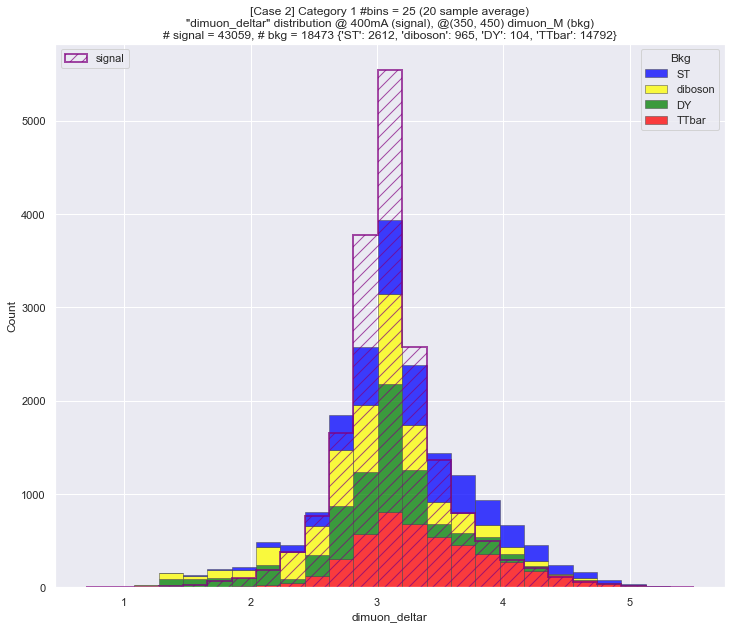

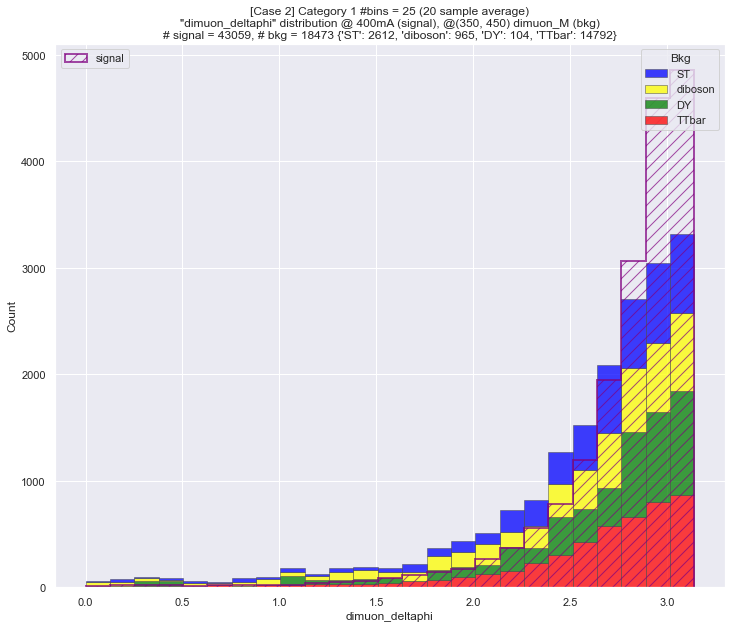

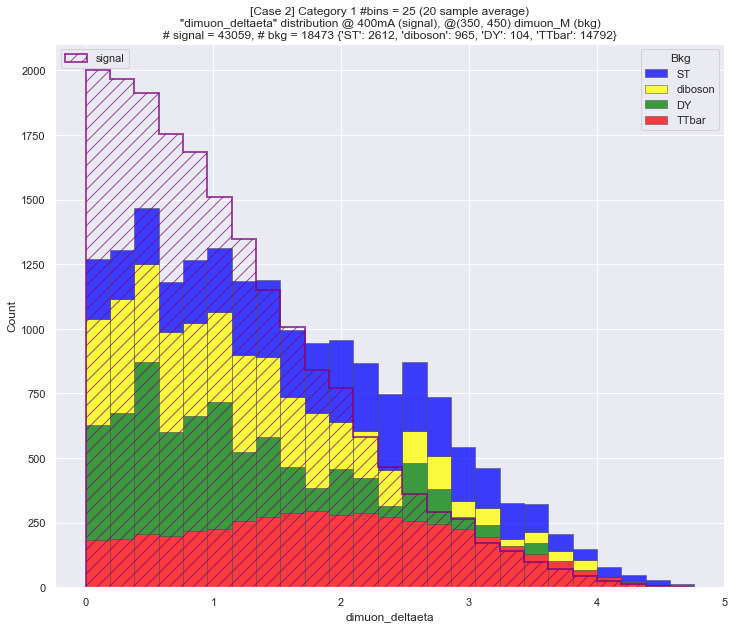

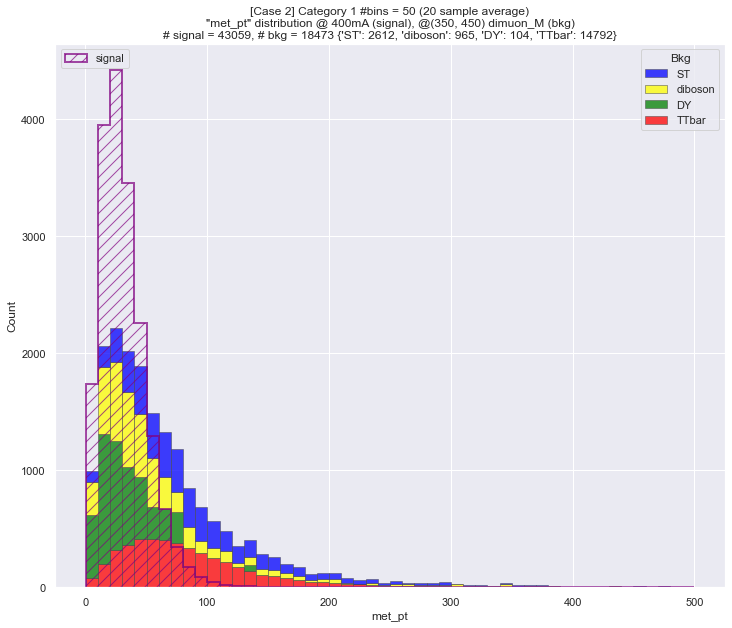

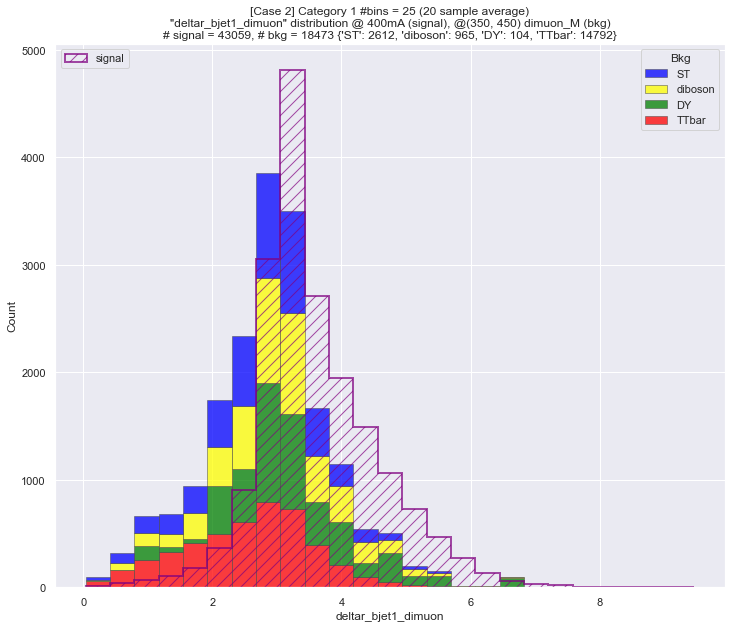

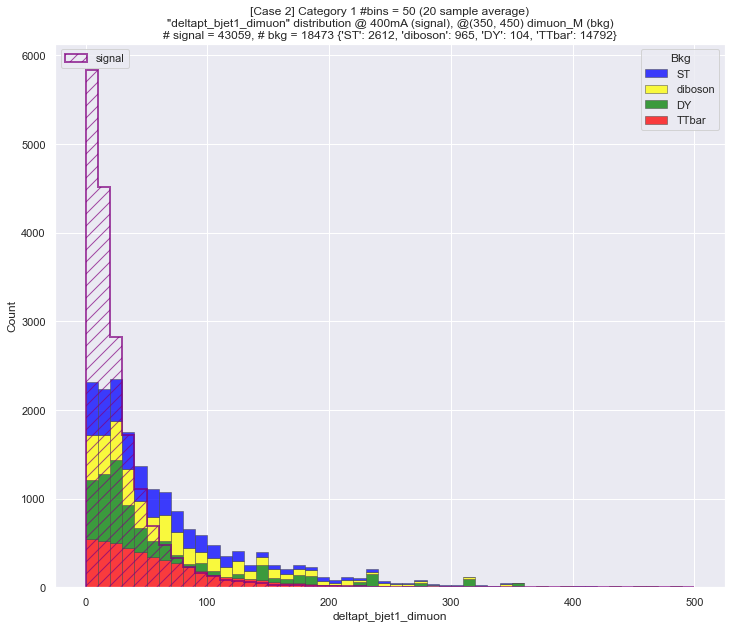

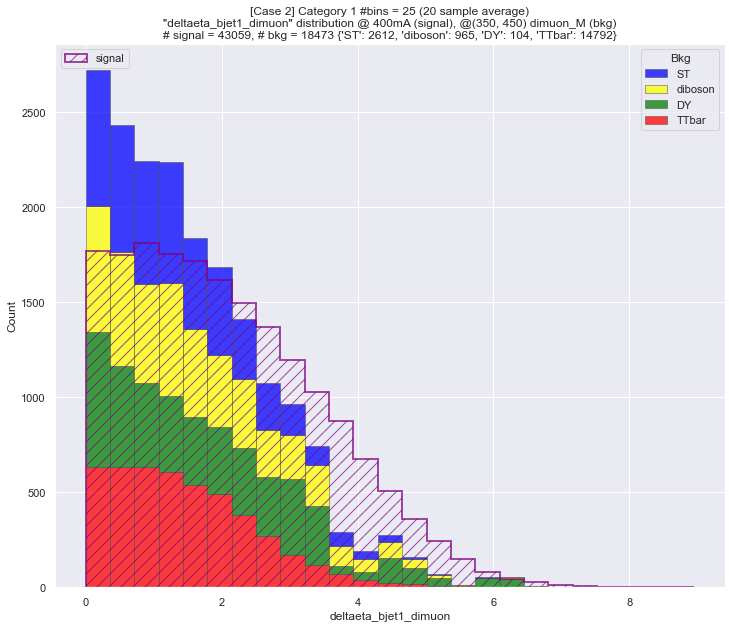

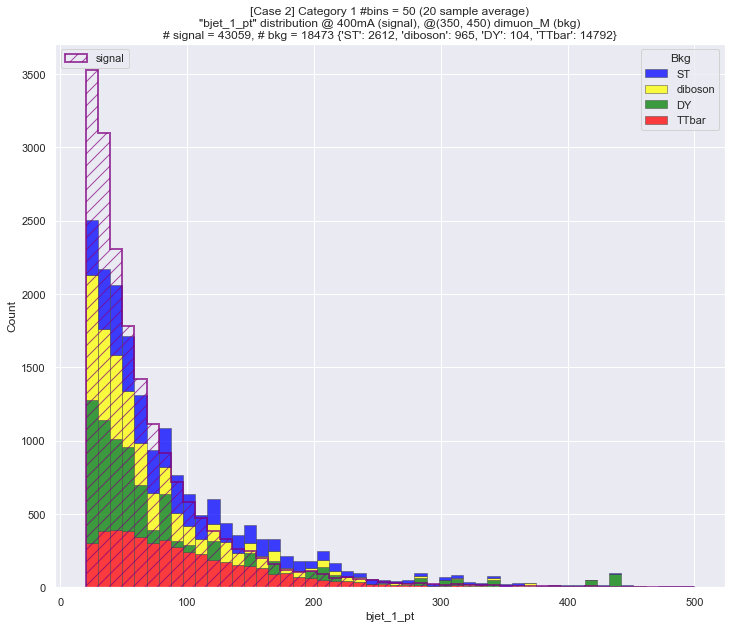

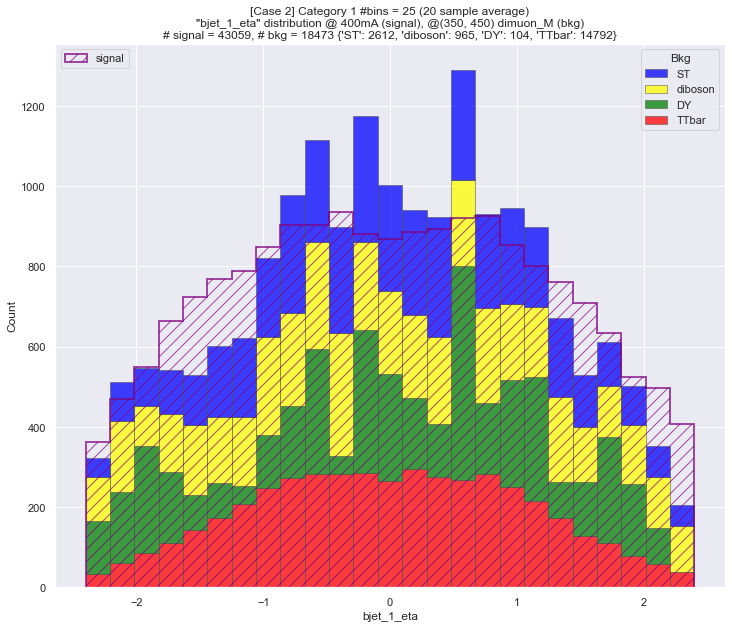

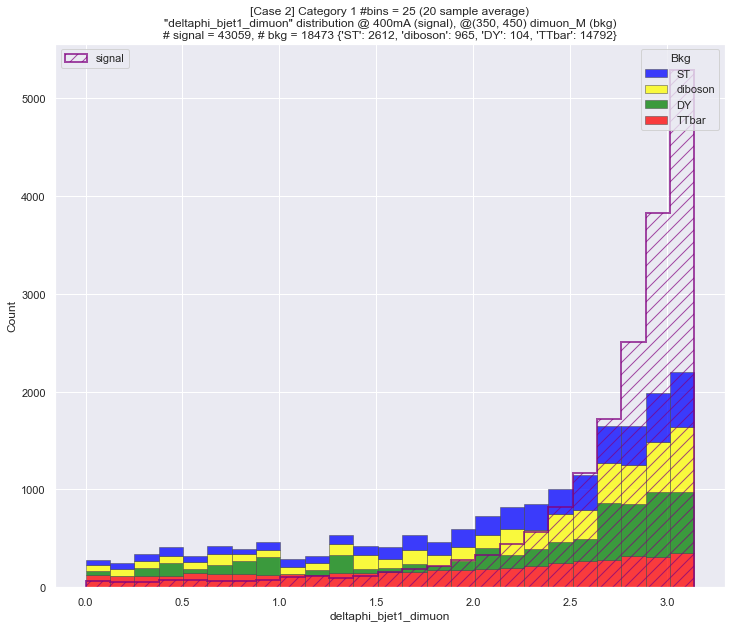

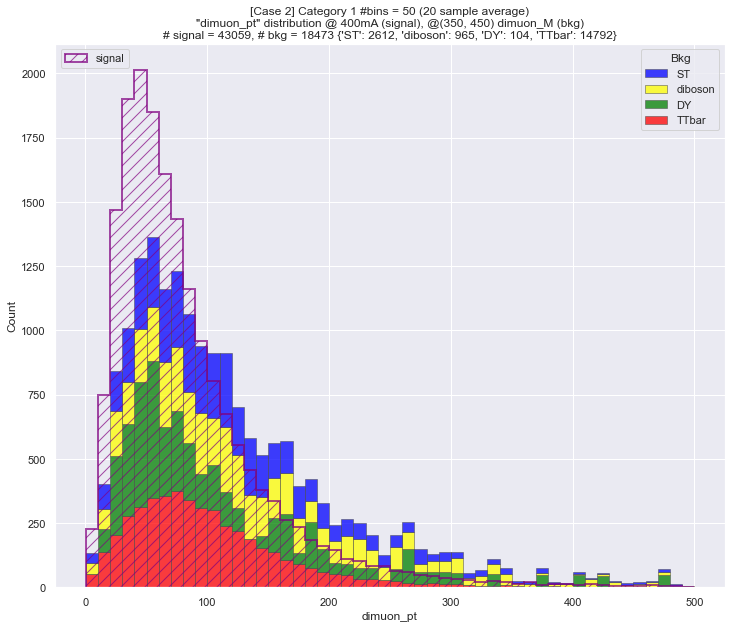

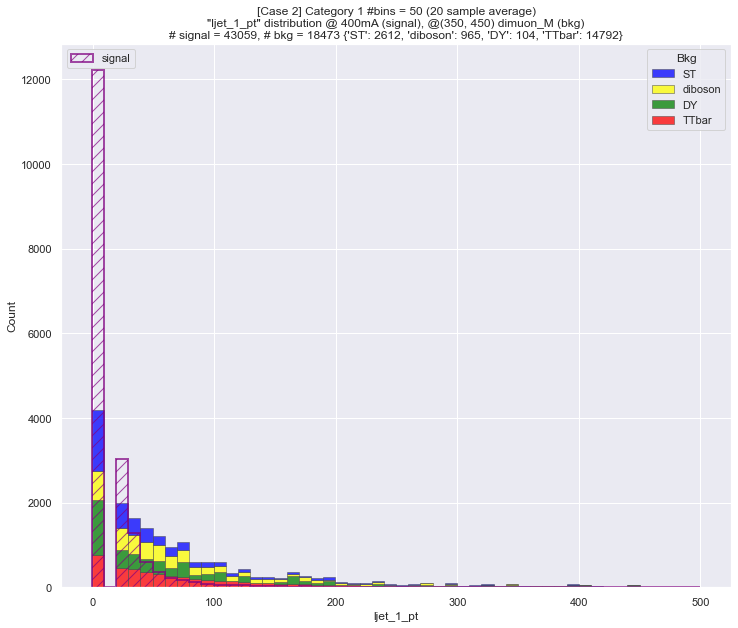

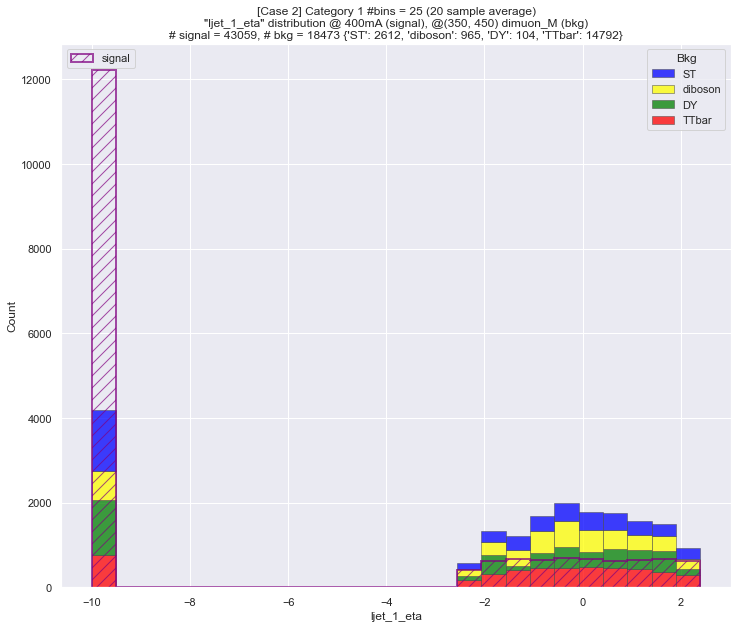

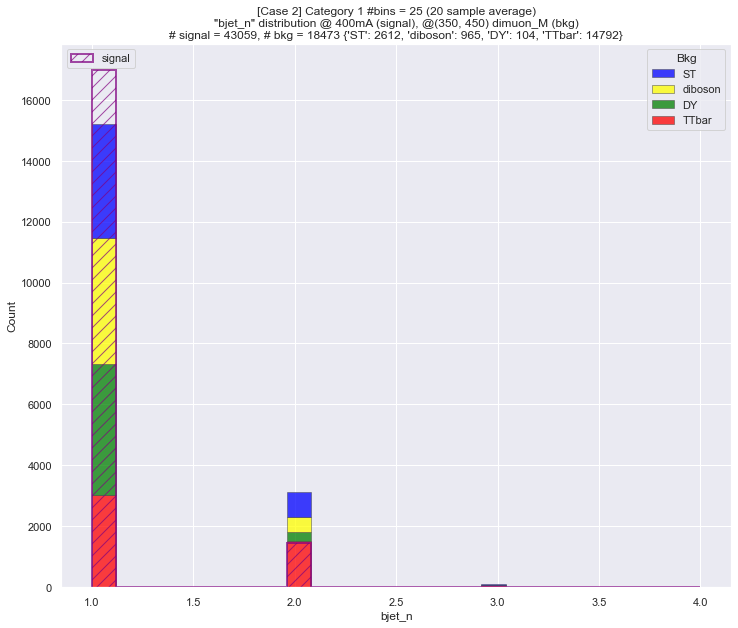

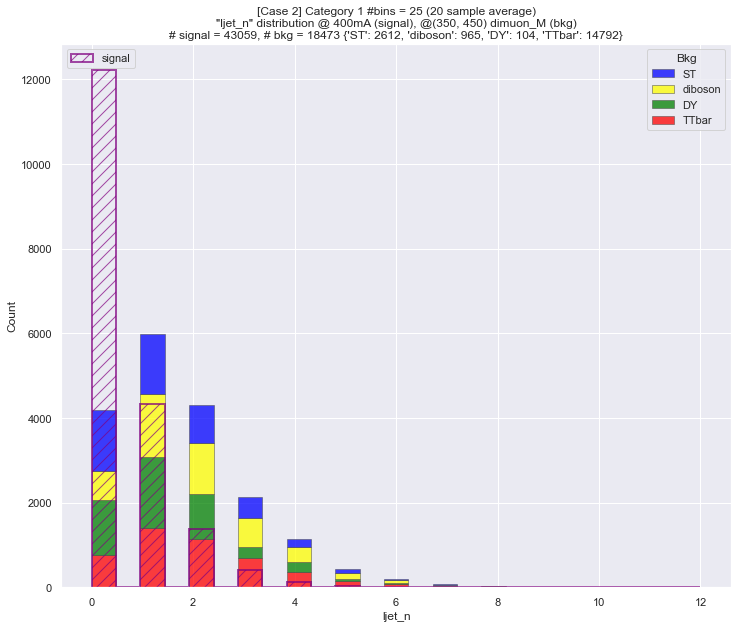

In [12]:
for var in VAR_CAT1:
    if ('met' in var) or ('pt' in var):
        bins = 50
        max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot2(data, col=var, mass=400.0, average=20, bins=bins, delta=50.0, balance_bkg=True,
                  cat=1,
                  path='plot/case2/bbH/', save=f'{var}_400mA', max_limit=max_limit)

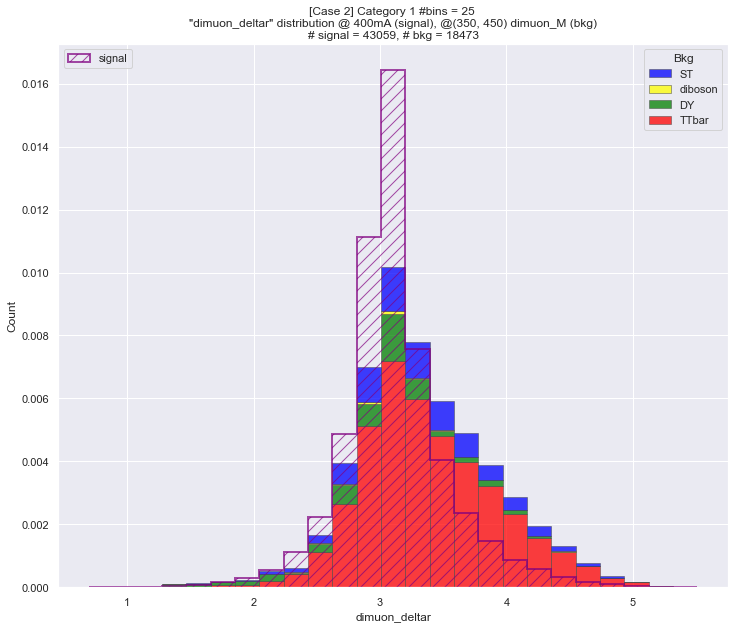

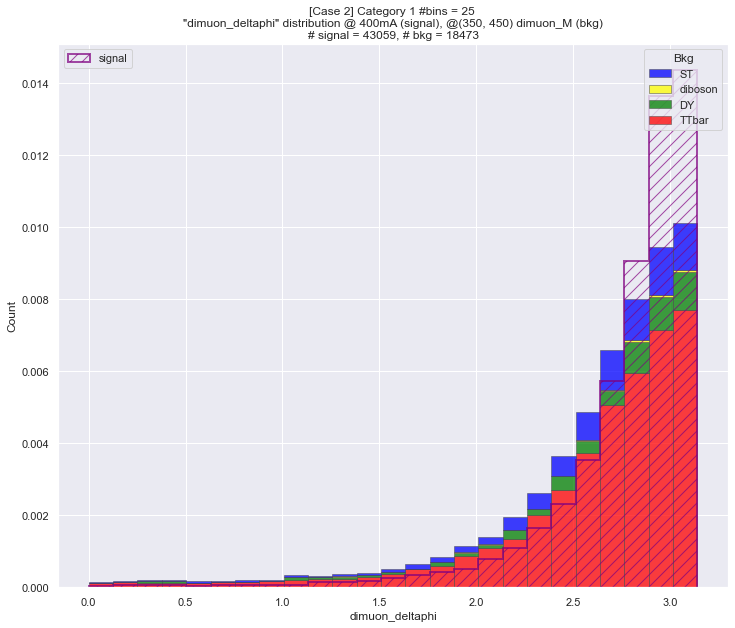

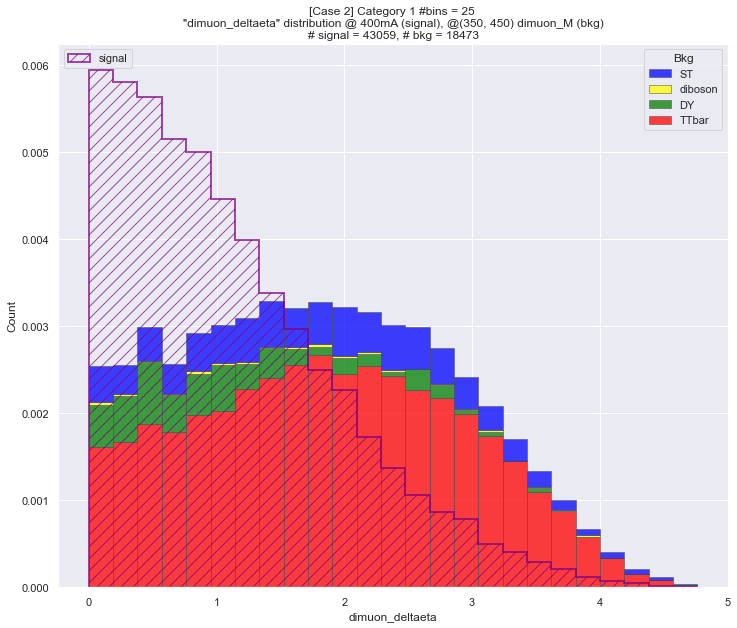

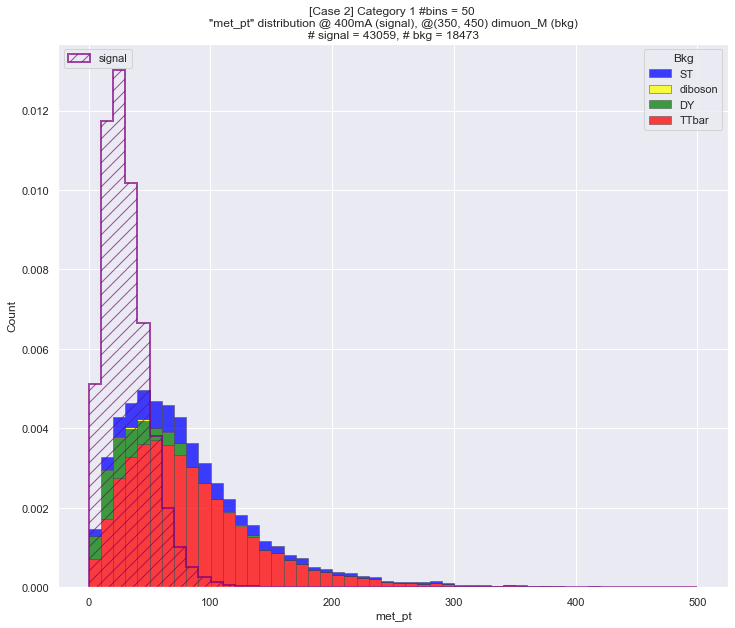

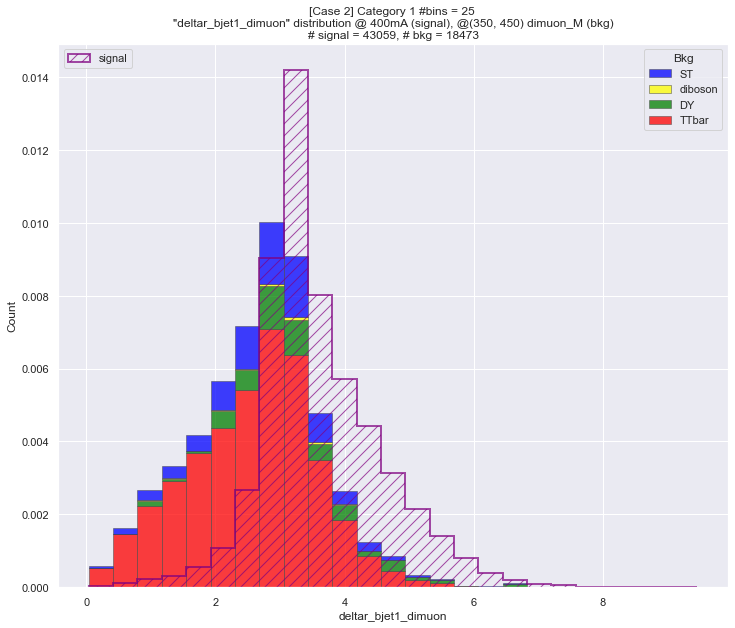

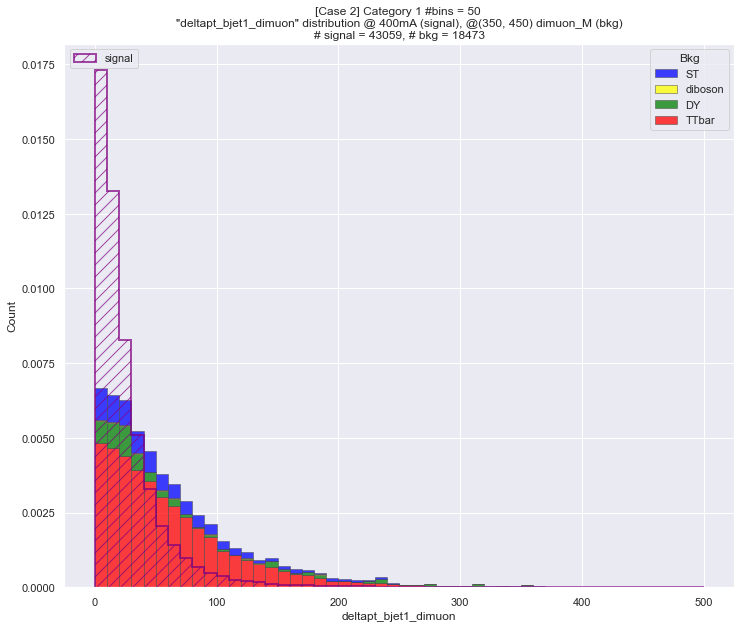

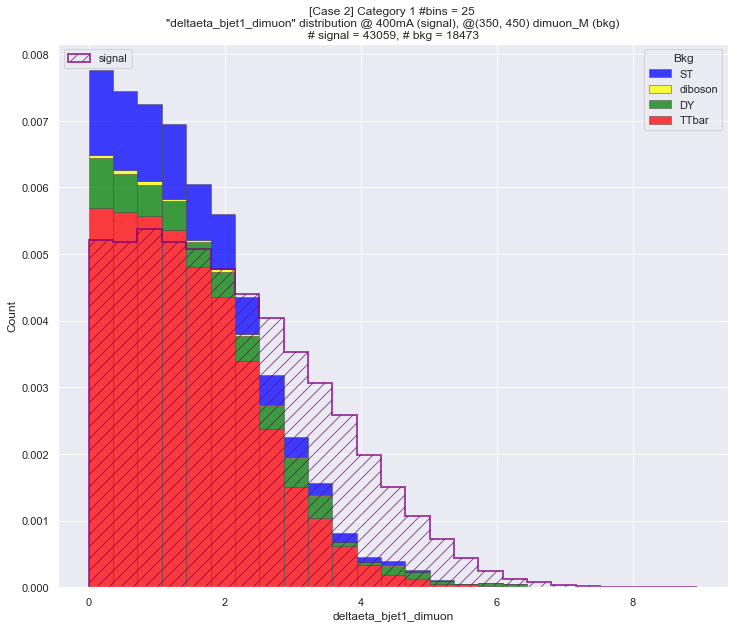

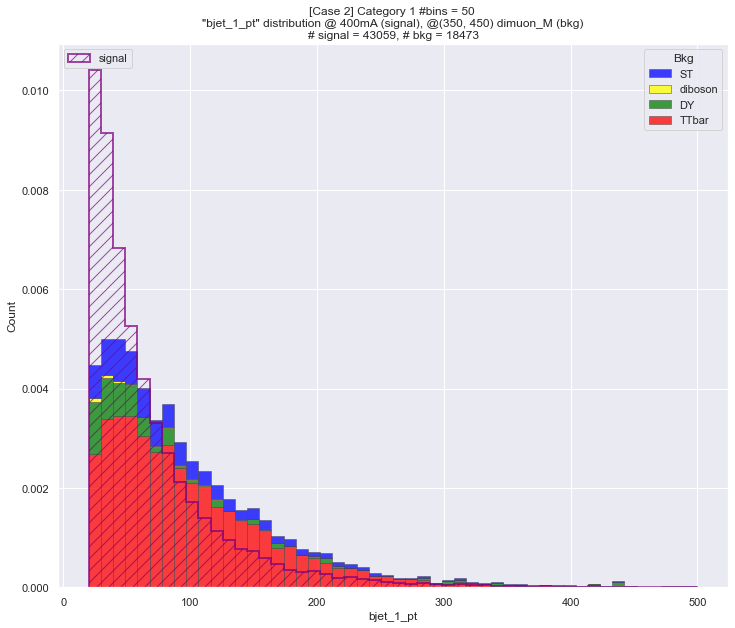

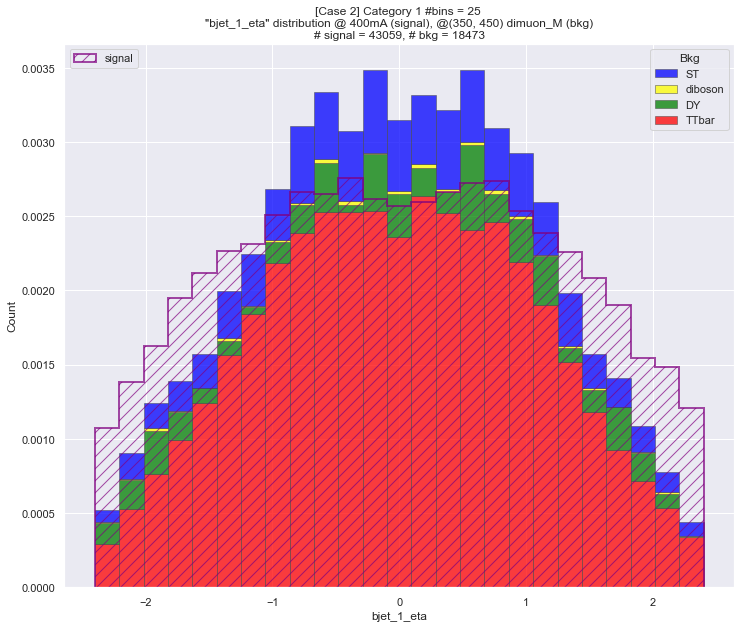

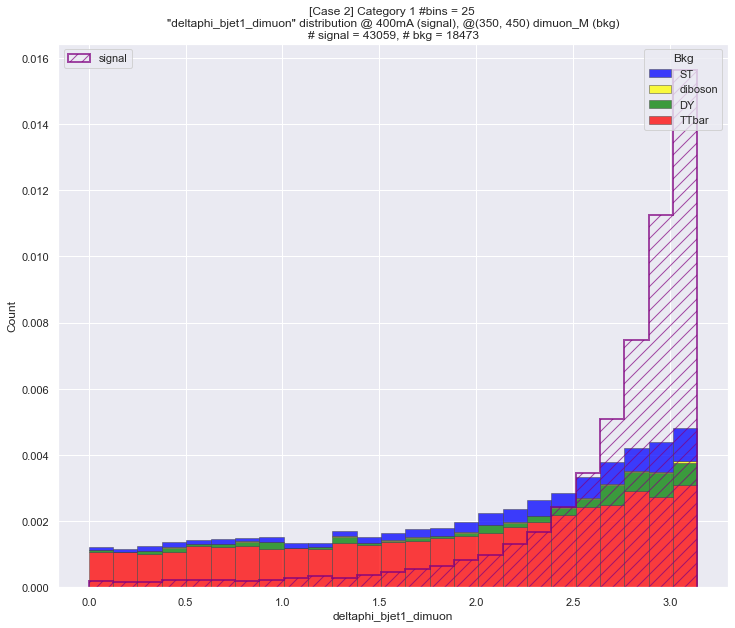

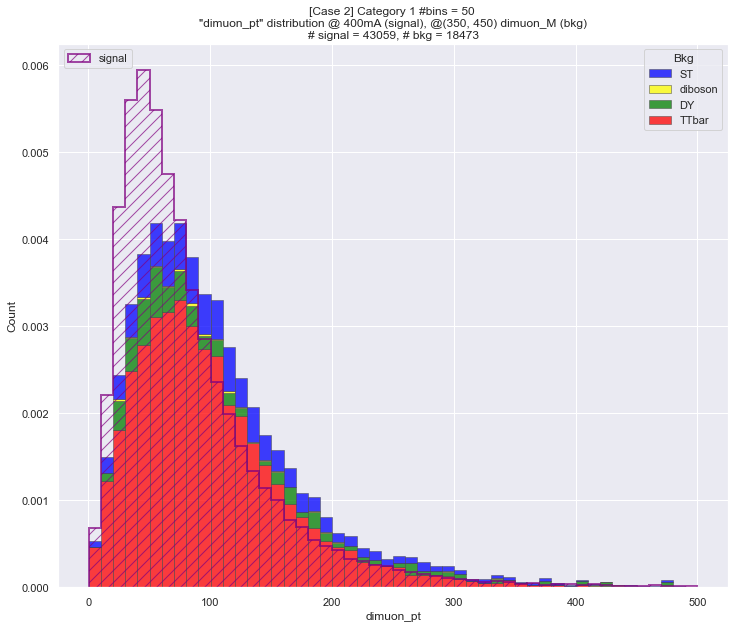

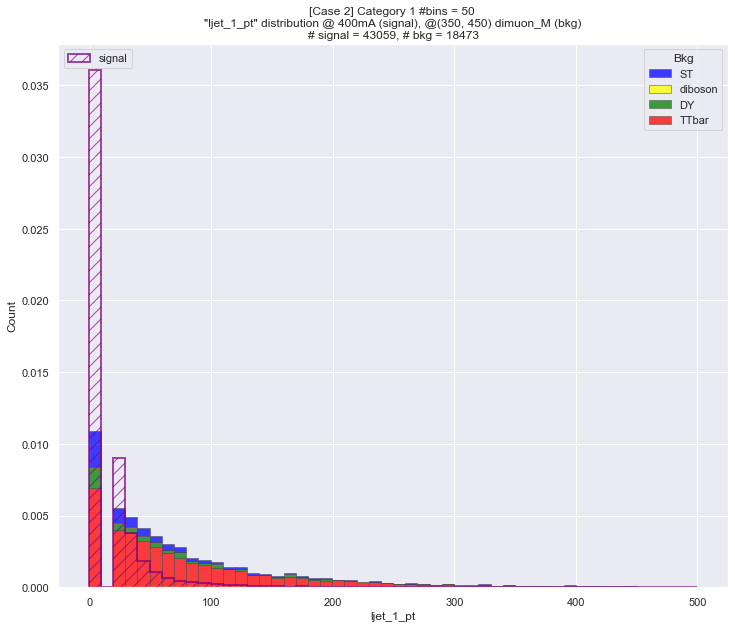

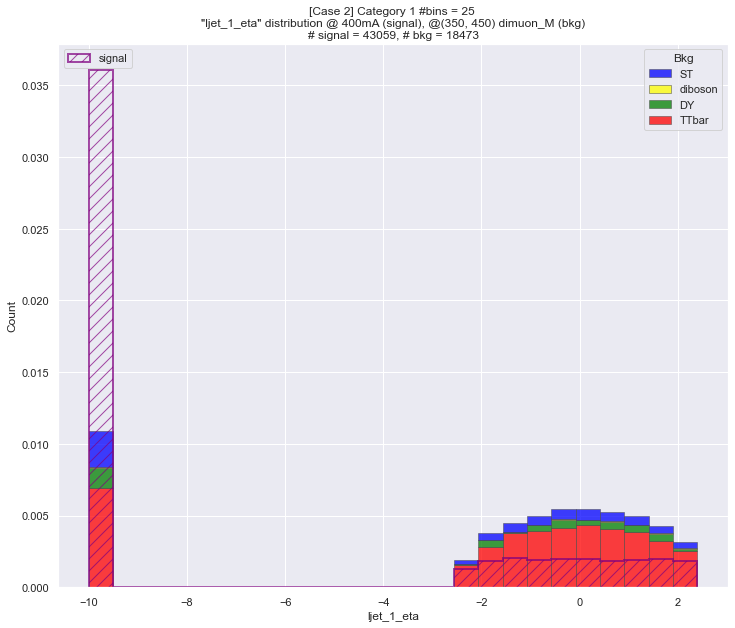

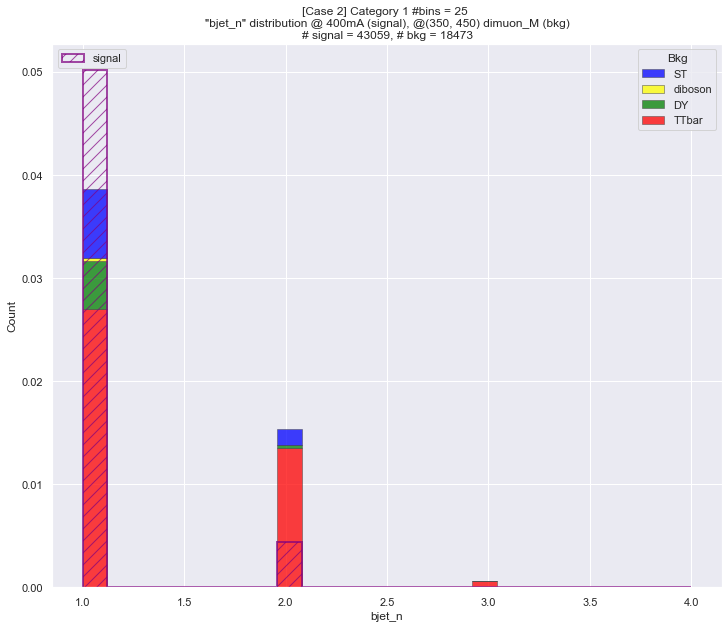

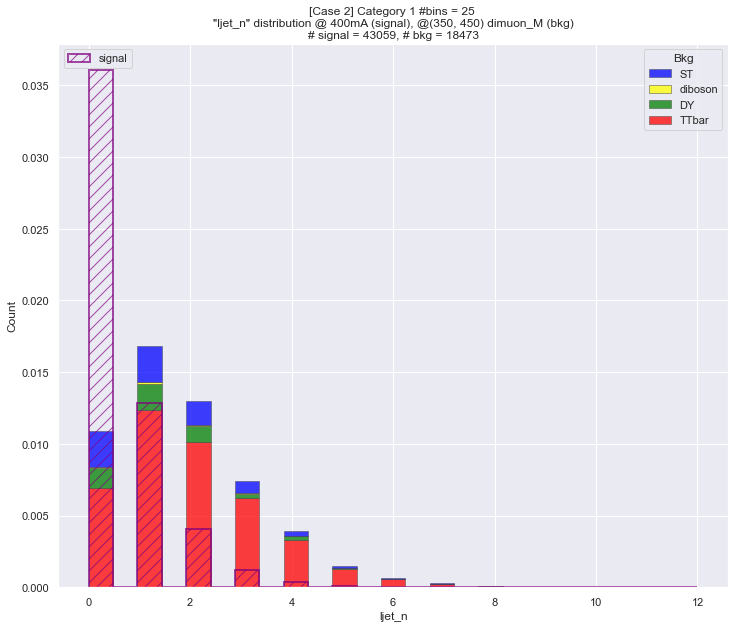

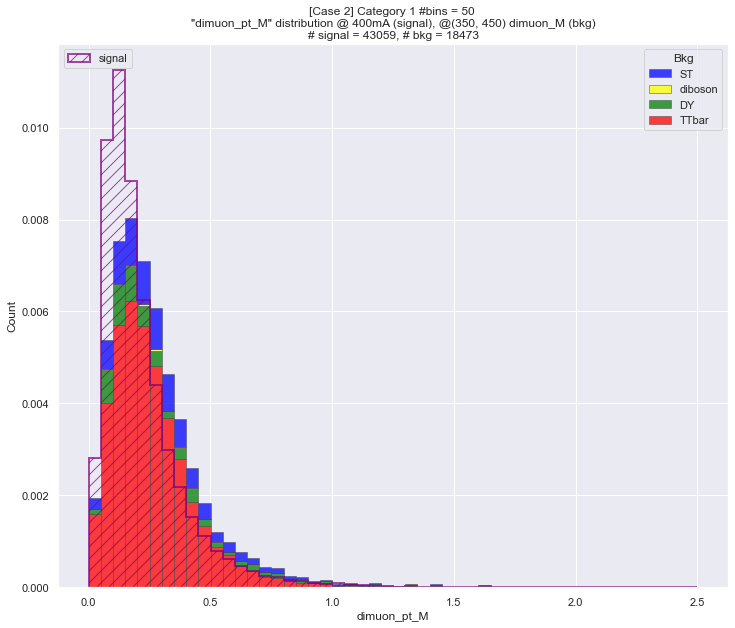

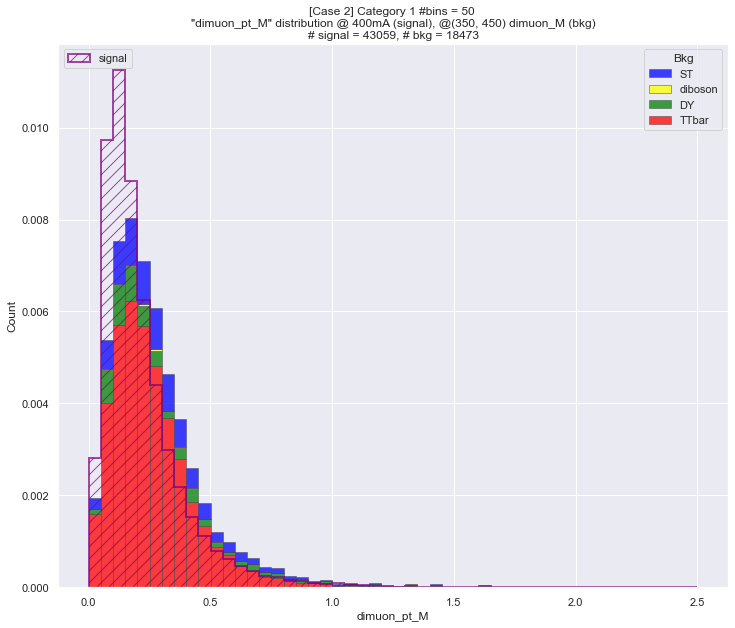

In [34]:
for var in VAR_CAT1:
    if ('met' in var) or ('pt' in var):
        bins = 50
        
        if var == 'dimuon_pt_M':
            max_limit = 2.5
        else:
            max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot2(data, col=var, mass=400.0, average=1, bins=bins, delta=50.0, balance_bkg=False,
                  cat=1, weight=True,
                  path='plot/case2/bbH/weigted', save=f'{var}_400mA', max_limit=max_limit)

#### Category 2

In [35]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat2.csv', 
          bkg='data/new/background_cat2.csv', feature_columns=VAR_CAT2, add_var=True)

[signal] loading...
[background] loading...
[Dataset] loaded.


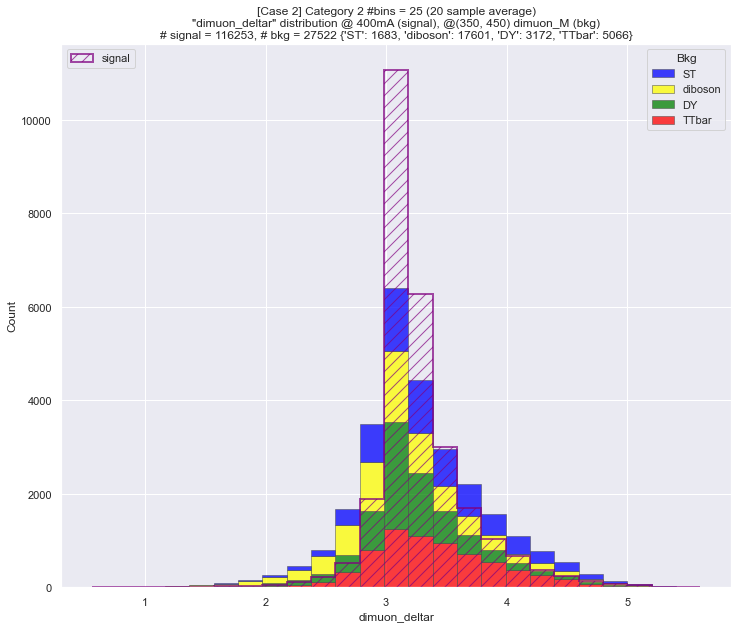

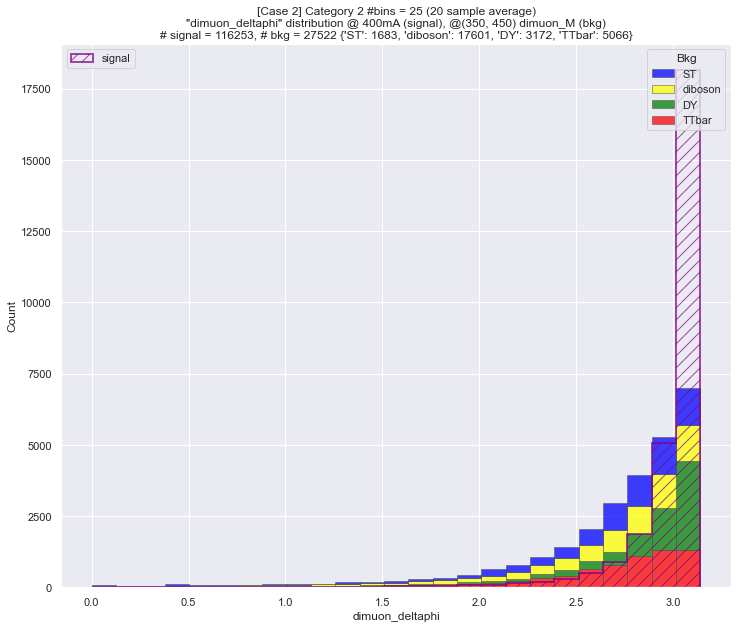

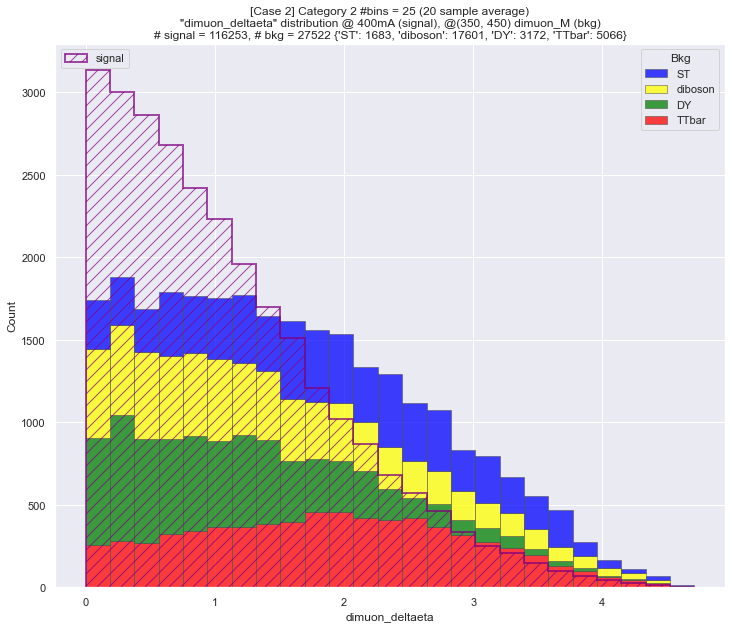

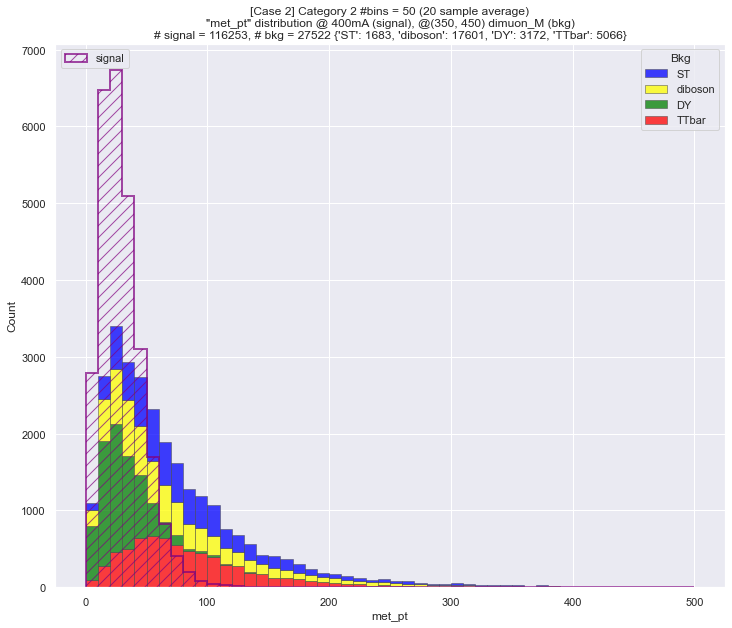

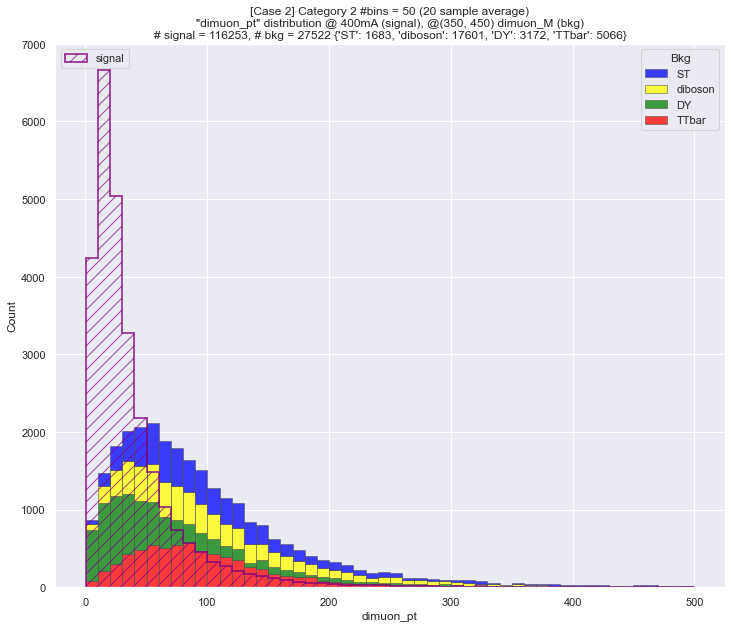

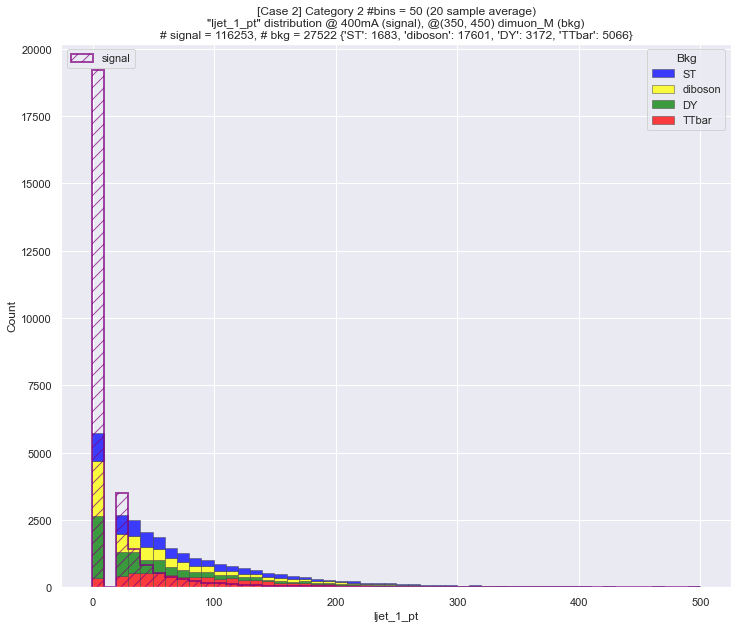

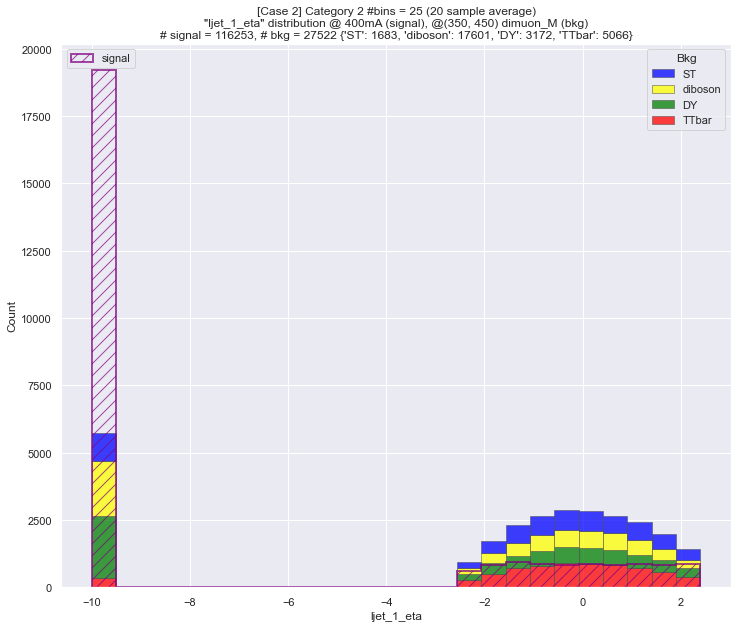

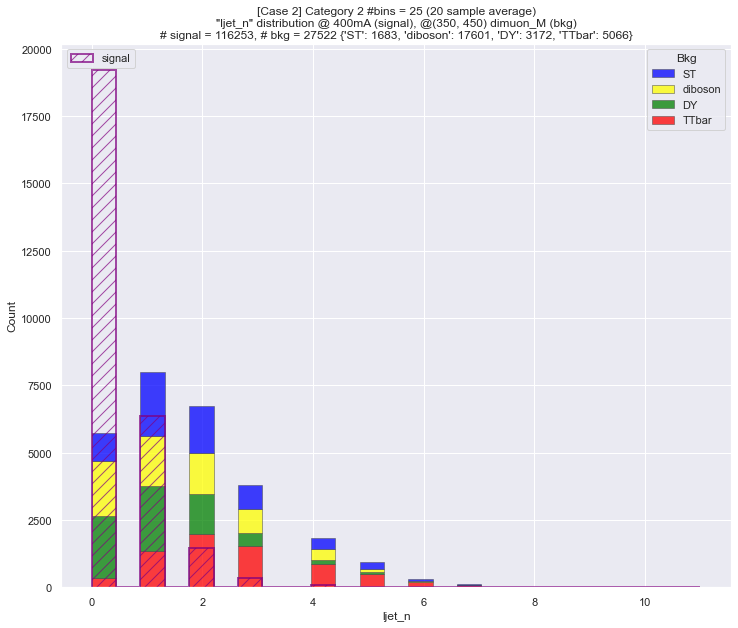

In [14]:
for var in VAR_CAT2:
    if ('met' in var) or ('pt' in var):
        bins = 50
        max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot2(data, col=var, mass=400.0, average=20, bins=bins, delta=50.0, balance_bkg=True,
                  cat=2,
                  path='plot/case2/bbH/', save=f'{var}_400mA', max_limit=max_limit)

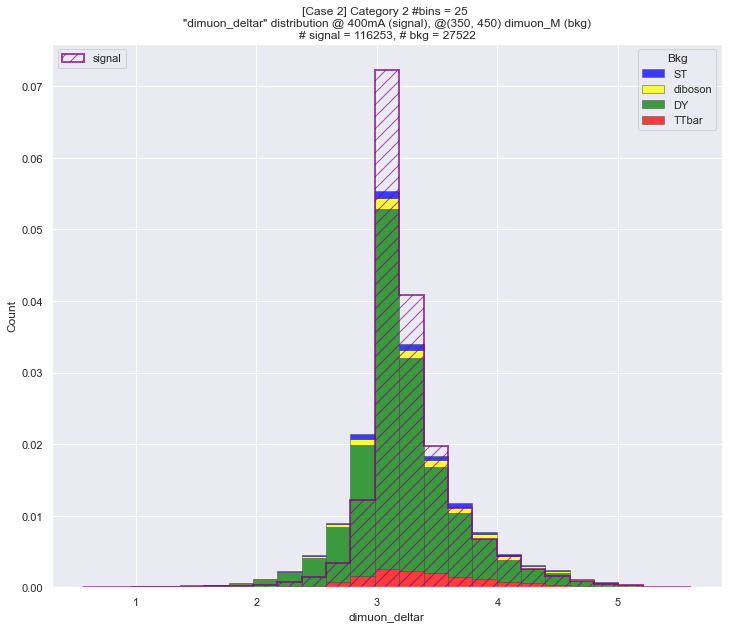

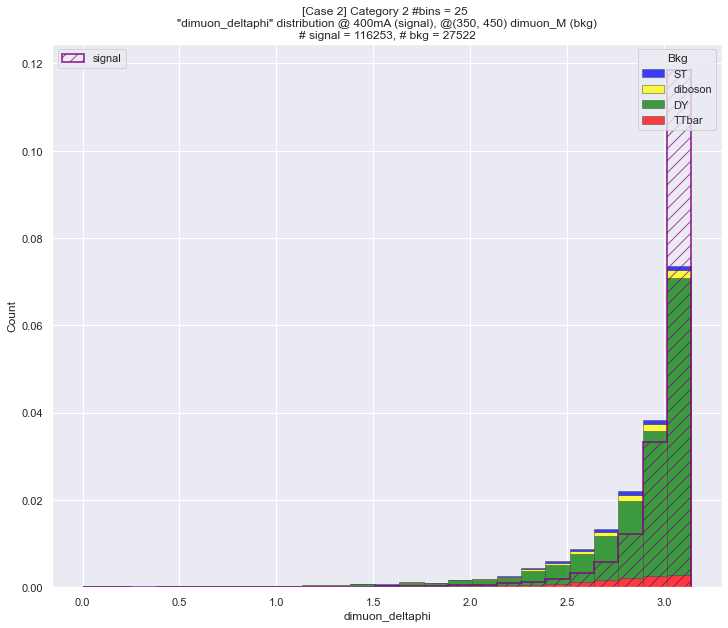

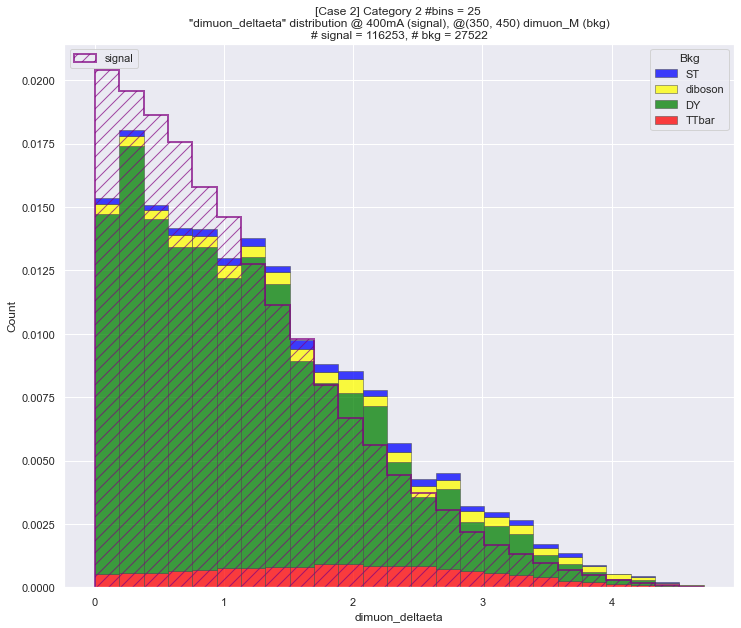

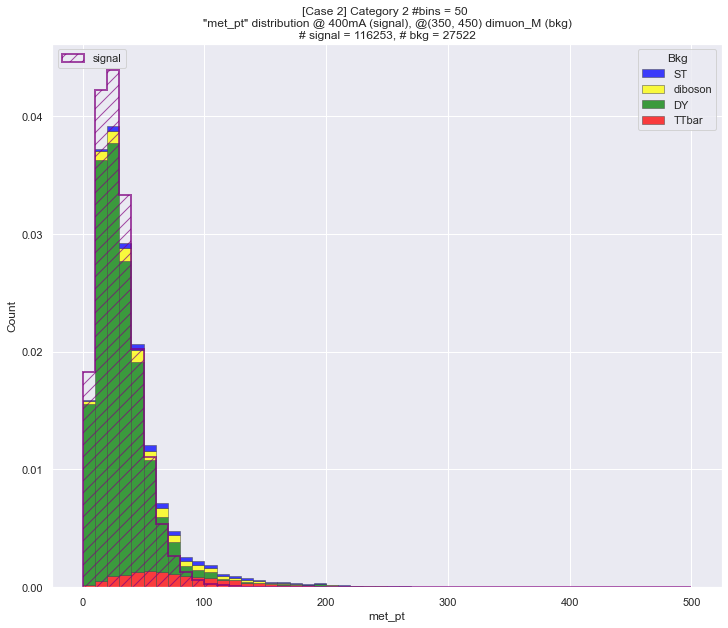

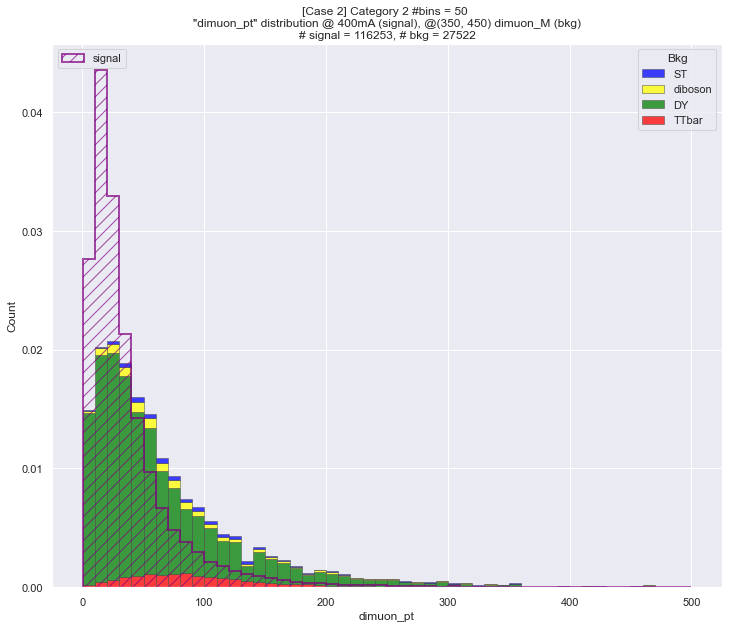

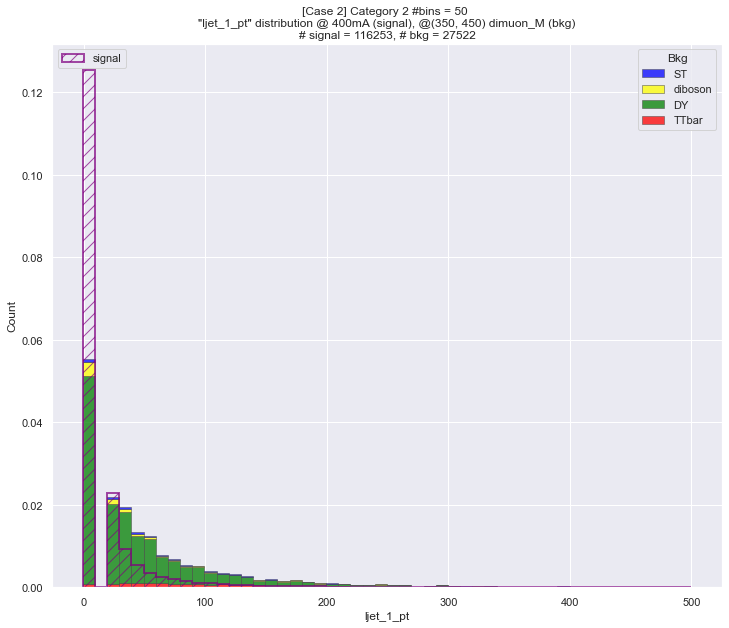

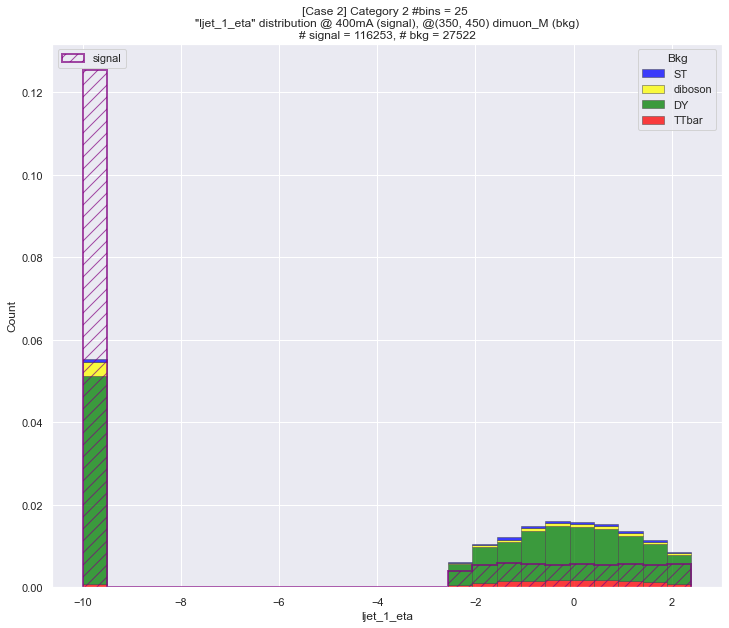

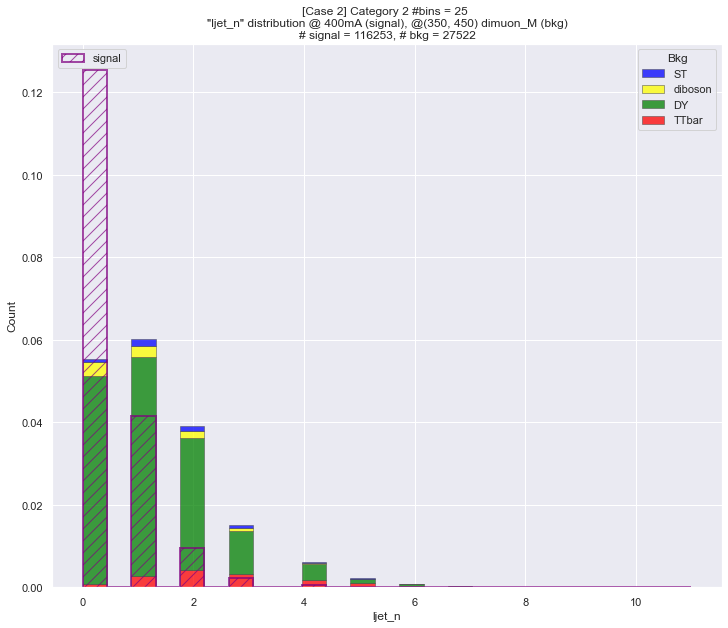

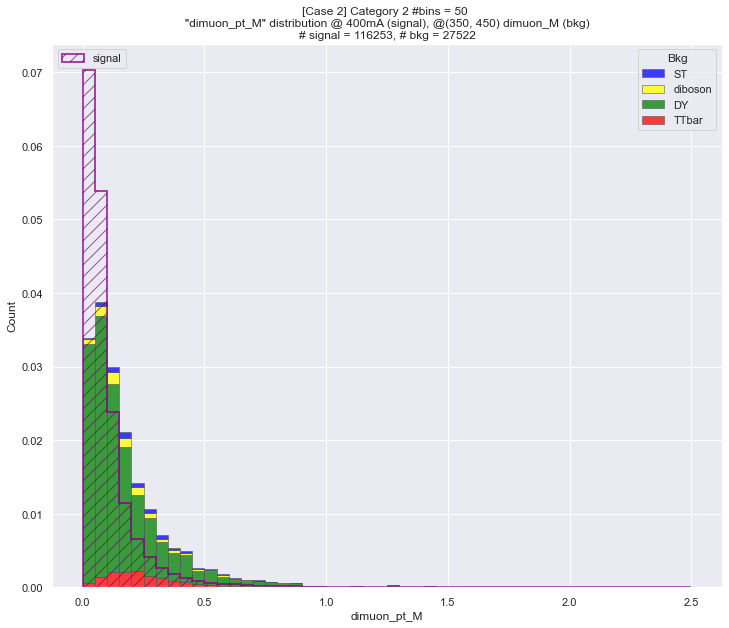

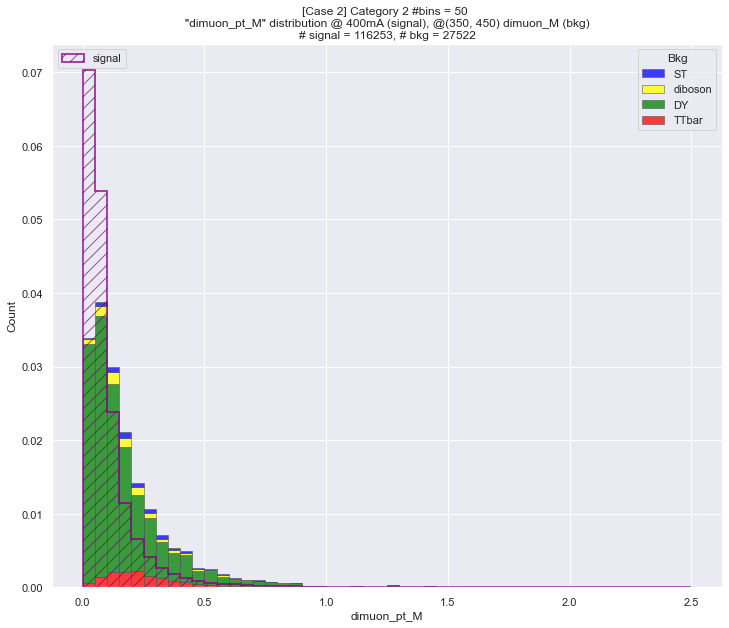

In [37]:
for var in VAR_CAT2:
    if ('met' in var) or ('pt' in var):
        bins = 50
        
        if var == 'dimuon_pt_M':
            max_limit = 2.5
        else:
            max_limit = 500.0
    else:
        bins = 25
        max_limit = None
        
    cms_histplot2(data, col=var, mass=400.0, average=1, bins=bins, delta=50.0, balance_bkg=False,
                  cat=2, weight=True,
                  path='plot/case2/bbH/weigted', save=f'{var}_400mA', max_limit=max_limit)